# **MÓDULO A4**

In th's project, we'll try to understand and exercise the RNN (Recurrent Neural Network). I decided to use 'International Airline Passengers' dataset for this workout. You'll see:
* Data Loading and Reading
* Data Preprocessing (Scaling, Train-Test Datas Split, Reshaping)
* RNN with Keras
* Predictions and Visualizations
* Conclusion

in this project.

## Import

In [284]:
# !pip uninstall hana_ml

In [285]:
# !pip install fbprophet

In [286]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import math

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, LSTM, GRU, Bidirectional
# from tensorflow.keras.models import load_model # returns a compiled model
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest
# from sklearn.preprocessing import StandardScaler

from ThymeBoost import ThymeBoost as tb  # Detecção de anomalia

import statsmodels.api as sm
# from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import researchpy as rp
from scipy.stats import shapiro, normaltest, ttest_ind, mannwhitneyu, probplot, levene


from fbprophet import Prophet
import hana_ml  # excluir
from hana_ml.dataframe import ConnectionContext

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

%matplotlib inline
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# Semente para reprodução de experimentos aleatórios
RANDOM_SEED = 42

## Loading Data

### Mesclagem dos dados

In [350]:
# Procedimento para realizar a mesclagem dos arquivos 
def merge_files(
    input_folder, 
    output_folder, 
    output_file='output_',
    skiprows=0):
    # Mesclar os arquivos e exporta para uma pasta local
    import pandas as pd
    from os import listdir
    from os.path import isfile, join  

    # obtendo a lista de arquivos na pasta
    files = [f for f in listdir(input_folder) if isfile(join(input_folder, f))]
    df_to_export = pd.DataFrame()

    # Varre todos arquivos da pasta
    for i in range(len(files)):
        complete_file_path = input_folder + files[i]
        # carregando o arquivo
        df = pd.read_csv(
            complete_file_path, 
            skiprows=skiprows, delimiter =';', 
            encoding="latin-1", 
            error_bad_lines = True,
            warn_bad_lines=True
            )
        # Apaga colunas Unnamed
        df.drop(
            df.columns[df.columns.str.contains(
                'Unnamed', case=False)], 
                axis=1, inplace=True)
        
        # mesclando os arquivos
        df_to_export = pd.concat([df_to_export, df], ignore_index=True)

    df_to_export.drop_duplicates(keep = 'last', inplace = True)
    # Exportando arquivo
    df_to_export.to_csv(
        output_folder + output_file + '.csv', sep=';',
        index=None,
        header=True,
        encoding="utf-8"
    )

In [288]:
# # import pandas as pd
# input_folder = "D:/dados/antt/fretamento/"
# output_folder = "../../dataset/raw/"
# output_file ='data_fret'
# # merge_files( input_folder, output_folder, output_file, skiprows=0)

### Funções para Carregamento dos Dados

In [289]:
def filtering_features(
    dataframe, 
    campos_cidades=[],
    cidade_uf=''):
    # Filtra o local de referência (origem ou destino) da viagem e retorna um dataframe Pandas
    # Argumentos:
    # - dataframe: dataframe resultante do processo anterior    
    # - campos_cidade (opcional): campo de referência contendo cidade e uf.
    #   Se não for fornecido, nenhum cidade é filtrada
    # - cidade_uf(opcional): nome e uf da cidade a ser filtrada
    #   Se não for fornecido, nenhum cidade é filtrada


    # Eliminando registro em que data_inicio_viagem é vazia
    dataframe = dataframe[dataframe['data_inicio_viagem'].isna()==False]
    # Eliminando registro em que data_fim_viagem é vazia
    dataframe = dataframe[dataframe['data_fim_viagem'].isna()==False]
    # Eliminando registros em que a data de término seja anterior à data de início
    dataframe = dataframe[dataframe['data_inicio_viagem']<=dataframe['data_fim_viagem']]

    
    # Filtrando pelo campo e localidade de referência
    if len(campos_cidades) != 0:
        total_linhas = dataframe.shape[0]
        dataframe = \
            dataframe[(dataframe[campos_cidades['cidade']] == cidade_uf['cidade']) & (
                dataframe[campos_cidades['uf']] == cidade_uf['uf'])]
        percentual = np.round(dataframe.shape[0]/total_linhas*100, 2)
        print(f'Percentual de viagens filtradas: {percentual} %')
        
    return dataframe

def filling_missing_data(dataframe):
    # Checa se estão faltando datas no intervalo em estudo
    # e retorna um dataframe
    # Argumentos:
    # - dataframe: dataframe resultante do processo anterior

    # transnformando valores 0 da serie em NaN
    dataframe['total_passageiros'][dataframe['total_passageiros']==0] = np.nan
    
    # obtendo a lista de valores faltantes
    df_missing_data = dataframe[dataframe['total_passageiros'].isna()] 
    percentual = np.round(df_missing_data.shape[0]/dataframe.shape[0]*100, 2)
    print(f'Dados faltantes: {df_missing_data.shape[0]}')
    print(f'Total de linhas: {dataframe.shape[0]}')

    print(f'Percentual de dados faltantes: {percentual} %')
    print(df_missing_data)

    # preenchendo os valores faltantes com o método  interpolate 
    # e argumento method='time'     
    dataframe = dataframe.interpolate(method='time').astype(int)
    
    del df_missing_data

    return dataframe

def handle_outliers(dataframe, outliers_params):
    # Checa se existem outliers nos dados
    # e retorna um dataframe
    # Argumentos:
    # - dataframe: dataframe resultante do processo anterior
    # - remove_outliers: False - não remover outliers; True - remove outliers

    def fit_predict_model(dataframe, outliers_params):     
        # fonte: https://neptune.ai/blog/anomaly-detection-in-time-series
        # Contrói um modelo de previsão de dados
        # e retorna os dados previstos
        # Argumentos:
        # - dataframe: dataframe resultante do processo anterior
        #  interval_width: intervalo de incerteza

        m = Prophet(
            daily_seasonality = outliers_params['daily_seasonality'], 
            yearly_seasonality = outliers_params['yearly_seasonality'], 
            weekly_seasonality = outliers_params['weekly_seasonality'],
            # monthly_seasonality = True,
            seasonality_mode = outliers_params['seasonality_mode'],
            interval_width = outliers_params['interval_width'])

        m = m.fit(dataframe)
        forecast = m.predict(dataframe)
        forecast['fact'] = dataframe['y'].reset_index(drop = True)

        return forecast


    def detect_anomalies(forecast):
        # fonte: https://neptune.ai/blog/anomaly-detection-in-time-series
        # Detecta outliers 
        # e retorna os dados previstos
        # Argumentos:
        # - forecast: dataframe resultante modelo obtido

        # Detecta anomalias com base nos limites dos valores superiores e inferiores
        # obtidos na função fit_predict_model
        # Estes limites são definidos pelos intervalos de incerteza interval_width = 0.99
        forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
        forecasted['anomaly'] = 0
        forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
        forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

        forecasted['importance'] = 0    
        forecasted.loc[forecasted['anomaly'] == 1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
        forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']

        return forecasted
    

    data_outlier = dataframe
    data_outlier['ds'] = dataframe.index
    data_outlier = data_outlier[['ds', 'total_passageiros']]
    data_outlier.rename(columns={'total_passageiros':'y'}, inplace=True)
    data_outlier['ds'] = pd.to_datetime(data_outlier['ds'])

    pred = fit_predict_model(data_outlier, outliers_params)
    pred = detect_anomalies(pred)

    total_outliers = pred['anomaly'][pred['anomaly']!= 0].shape[0]
    print(f"Total de outliers: {total_outliers}")
    print(f"Percentual de outliers: {np.round(total_outliers/dataframe.shape[0]*100, 1)} %")
    
    # se remove_outliers = True, remove os outliers
    if outliers_params['remove_outliers']:
        dataframe['anomaly'] = pred['anomaly'].values
        dataframe['yhat'] = pred['yhat'].values

        dataframe['pass_corrigido'] = dataframe.apply(
            lambda x: int(x.yhat) if x.anomaly != 0 else x.total_passageiros, axis=1)
        dataframe['total_passageiros'] = dataframe['pass_corrigido']
        dataframe.drop(columns=[ 'pass_corrigido', 'anomaly', 'yhat'])

    return dataframe.drop(columns=['ds'])


def groupby_day(
    dataframe, 
    start_date_field,
    end_date_field):
    # Agrupa os dados por dia de acordo com o campo de data de final de referencia e 
    # retorna um dataframe
    # Argumentos:
    # - dataframe: dataframe resultante do processo anterior
    # - date_input: data de entrada (data_inicio_viagem, data_fim_viagem)
    # Se a date_input for igual a data_inicio_viagem a serie é obtida a série com base na origem da viagem
    # se a date_input for posterior a data_inicio_viagem, a série obtida baseia-se no destino da viagem

    # Transforma data_inicio_viagem e date_input em datetime
    dataframe[start_date_field] = pd.to_datetime(
        dataframe[start_date_field], infer_datetime_format=True)     
    dataframe[end_date_field] = pd.to_datetime(
        dataframe[end_date_field], infer_datetime_format=True)
    
    # Obtém o número de dias entre a data de referência (início ou fim da viagem)
    # e a data de inicio da viagem
    dataframe['dias'] = \
       (dataframe[end_date_field] - dataframe[start_date_field]).dt.days
    
    # Obtém a data no local de referencia
    dataframe['dias'] = dataframe['dias'].apply(lambda x: math.ceil(x/2))
    dataframe['data_ref'] = dataframe[start_date_field] +\
         pd.to_timedelta(dataframe['dias'], unit='d')

    
    # Agrupa a série pela data de referência
    dataframe = dataframe.groupby(
       'data_ref', group_keys=False)["total_passageiros"].sum().reset_index()
    dataframe['index'] = dataframe['data_ref']
    dataframe = dataframe.set_index(['index'])  

    # Obtendo a série temporal diária 
    agg = {'total_passageiros':'sum'}
    dataframe = dataframe.resample('D', on='data_ref').agg(agg)

    return dataframe
    

def load_dataset(file_path):
    # Carrega o dataset e retorna um dataframe Pandas
    # Argumento:
    # - file_path: caminho do arquivo a ser carregado
    
    date_column = ['data_inicio_viagem', 'data_fim_viagem']
    dataframe = pd.read_csv(
        file_path, engine='python', 
        delimiter=';', 
        parse_dates=date_column,  #transforma as colunas da lista date_column em datetime
        dayfirst=True  # define o formato da data com o dia na primeira posição
        )    
    dataframe.drop_duplicates(inplace=True)

    return dataframe
    
def join_files(dataframe):
    # Inclui os atributos de feriado disponíveis no arquivo feriados_nacionais.csv e
    # retorna um dataframe Pandas 
    # Argumentos:
    # - dataframe: dataframe resultante do processo anterior

    # Carrega o arquivo contendo as datas com os feriados nacionais no período
    df_feriados = pd.read_csv(
        '../../dataset/raw/outros_atributos.csv',
        engine='python',
        delimiter=';')
    dataframe['data_ref'] = dataframe.index.to_series()

    # Transforma data_feriado em datetime
    df_feriados['data_feriado'] = pd.to_datetime(
        df_feriados['data_feriado'], format='%d/%m/%Y')   
           
    # Mescla os dataframes a partir da data de feriado
    dataframe = pd.merge(
        dataframe,
        df_feriados,
        left_index=True, right_on='data_feriado').drop(columns=['data_feriado'])   
    del df_feriados
    dataframe = dataframe.set_index(['data_ref'])  

    return dataframe    
    
def create_features(dataframe):
    # Cria feições temporais a partir da periodicidade
    # e retorna um dataframe Pandas 
    # Argumentos:
    # - dataframe: dataframe resultante do processo anterior    
    # - periodicidade: 'D' - diária (default), 'W' - semanal, 'M' - mensal
    
    date_series = pd.to_datetime(
            dataframe.index.to_series(), infer_datetime_format=True)

    # # Acrescenta uma coluna com uma nova feição: se a data é feriado ou não
    dataframe = join_files(dataframe)

    # Cria novas feições temporais com base na data de referência
    # Feições comuns a todas periodicidades
    dataframe['ano'] = date_series.dt.year   # intervalo: 2007...2019
    dataframe['trimestre'] = date_series.dt.quarter  # intervalo: 1...4
    dataframe['mes'] = date_series.dt.month  # intervalo: 1...12
    # Feição comum às periodicidades semanal e diária
    dataframe['semana_do_ano'] = date_series.dt.weekofyear  # intervalo: 1...53
    # Feições da periodicidade diária
    dataframe['dia_do_ano'] = date_series.dt.dayofyear  # intervalo: 1...365
    dataframe['dia_do_mes'] = date_series.dt.day  # intervalo: 1...31
    dataframe['dia_da_semana'] = date_series.dt.dayofweek  # intervalo: 0...6
       
    return dataframe


def get_series(
    dataframe,
    periodicidade='D',
    ano_inicio=2007,
    ano_fim=2019):
    # Obtém a série temporalenriquecida e agregada por uma periodicidade e
    # retorna um dataframe Pandas 
    # Argumentos:
    # - dataframe: dataframe resultante do processo anterior
    # - periodicidade: 'D' - diária (default), 'W' - semanal, 'M' - mensal

    # Transforma a coluna de data de referência para o formato datetime
    dataframe['data_ref'] = pd.to_datetime(
        dataframe.index.to_series(), infer_datetime_format=True)    

    # Filtrando por ano de início
    dataframe = dataframe[dataframe['ano'] >= ano_inicio]
    # Filtrando por ano de término
    dataframe = dataframe[dataframe['ano'] <= ano_fim]

    # Define os atributos de agregação
    agg = {
        'total_passageiros':'sum',
        'feriado':'sum',
        'ano':'max',
        'trimestre':'max',
        'mes':'max',
        'semana_do_ano':'max',
        'dia_da_semana':'max',
        'dia_do_mes':'max',
        'dia_do_ano':'max'
        }
    # # Obtém o dataframe agregado de acordo com a periodicidade definida
    dataframe = dataframe.resample(periodicidade).agg(agg)             

    # Se a periodicidade for diária, transforma o índice em uma coluna datetime
    if periodicidade == 'D':
        date_series = pd.to_datetime(
                dataframe.index.to_series(), infer_datetime_format=True)         

    # Remove feições de nível diário para série semanal
    if periodicidade == 'W':
        dataframe.drop(columns=['dia_da_semana', 'dia_do_ano', 'dia_do_mes'], inplace=True)

    # Remove feições de níveis diários e semanais da série mensal
    # Configura o indice do dataframe para ano/mês 
    if periodicidade == 'M':
        dataframe = dataframe.set_index(dataframe.index.strftime('%Y/%m'))    
        dataframe.drop(columns=['dia_da_semana', 'dia_do_ano', 'dia_do_mes', 'semana_do_ano'], inplace=True)    

    print(f'Informações do Dataframe: {dataframe.info()}')
    
    return dataframe    
    

### Pipeline de Carregamento dos Dados

In [290]:
# Periodicidade da série ('M' - mensal 'W' - semanal e 'D' - diária)
periodicidade = 'D'

# Campos de referência das localidades:
# - município: municipio_origem, municipiodestino e
# - uf: uf_municipio_origem, uf_municipio_destino.
campos_cidades = {'cidade': 'municipiodestino', 'uf': 'uf_municipio_destino'}

# Cidade e UF de referência
cidade_uf = {'cidade': 'APARECIDA', 'uf': 'SP'}

# Parâmetros para detecção de outliers
outliers_params = {
    'interval_width': 0.99,  # intervalo de incerteza
    'daily_seasonality': False,  # sazonalidade diária
    'yearly_seasonality': False,  # sazonalidade anual
    'weekly_seasonality': True,  # sazonalidade semanal
    'seasonality_mode': 'additive',  # modelo de decomposição temporal aditivo
    'remove_outliers': False  # Não remove outliers
    }

# Caminho completo do arquivo
arquivo = '../../dataset/raw/data_fret.csv'
data = (
    load_dataset(arquivo)  # carregamento dos dados
    .pipe(filtering_features, campos_cidades, cidade_uf)  # filtragem de atributos cidades e NaN values
    .pipe(groupby_day, 'data_inicio_viagem',  'data_fim_viagem')  # agrupamento por dia
    .pipe(filling_missing_data)  # preenchendo valores faltantes
    .pipe(handle_outliers, outliers_params)  # Detecta e remove outliers para remove_outliers=True
    .pipe(create_features) # cria novas feições temporais
    .pipe(get_series, periodicidade, 2007, 2019)  # obtém a série temporal final com filtro de período
)

Percentual de viagens filtradas: 10.13 %
Dados faltantes: 523
Total de linhas: 5639
Percentual de dados faltantes: 9.27 %
            total_passageiros
data_ref                     
2006-12-05                NaN
2007-01-03                NaN
2007-01-19                NaN
2007-02-21                NaN
2007-02-23                NaN
...                       ...
2022-04-01                NaN
2022-04-04                NaN
2022-04-14                NaN
2022-05-06                NaN
2022-05-07                NaN

[523 rows x 1 columns]
Total de outliers: 148
Percentual de outliers: 2.6 %
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4748 entries, 2007-01-01 to 2019-12-31
Freq: D
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   total_passageiros  4748 non-null   int32
 1   feriado            4748 non-null   int64
 2   ano                4748 non-null   int64
 3   trimestre          4748 non-null   int64
 4 

### Time Series Outlier Detection with ThymeBoost

In [291]:
# # Detecção de outliers
# y = data['total_passageiros'].values
# boosted_model = tb.ThymeBoost()
# output = boosted_model.detect_outliers(y,
#                                        trend_estimator='linear',
#                                        seasonal_estimator='fourier',
#                                        seasonal_period=7,
#                                        global_cost='maicc',
#                                        fit_type='global')
# boosted_model.plot_results(output)
# boosted_model.plot_components(output)

In [292]:
output

,y,yhat,yhat_upper,yhat_lower,seasonality,trend
0,1946,2530.528795,9248.076656,-4187.019065,14.731068,2515.797727
1,89,2505.940492,9223.488352,-4211.607369,-10.125940,2516.066431
2,135,2477.406812,9194.954673,-4240.141048,-38.928323,2516.335136
3,182,2492.917940,9210.465800,-4224.629921,-23.685900,2516.603840
4,287,2509.762697,9227.310558,-4207.785163,-7.109847,2516.872544
...,...,...,...,...,...,...
4743,930,3785.618336,10503.166196,-2931.929525,-4.643493,3790.261828
4744,4400,3864.923791,10582.471651,-2852.624070,74.393258,3790.530532
4745,2725,3783.611298,10501.159159,-2933.936562,-7.187939,3790.799237
4746,501,3798.221290,10515.769151,-2919.326570,7.153349,3791.067941


#### Handling Outliers Using the Regularize Argument
Instead of passing an array of weights we could alternatively pass a string: ‘regularize’. ThymeBoost will now use a weighting scheme which will penalize higher error data points when approximating seasonality. This weighting, combined with multiple rounds of boosting, provides a similar treatment as a Iteratively Reweighted Least Squares method.



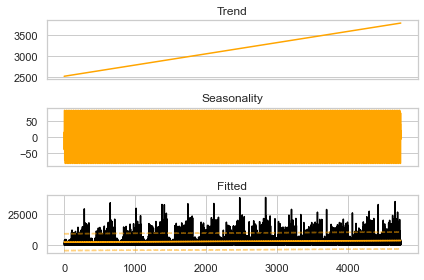

In [293]:
output = boosted_model.fit(y,
                           trend_estimator='linear',
                           seasonal_estimator='fourier',
                           seasonal_period=25,
                           global_cost='maicc',
                           fit_type='global',
                           seasonality_weights='regularize')
boosted_model.plot_components(output)

### Anomaly Detection Model on Time Series Data using Isolation Forest

In [294]:
# model_if =  IsolationForest(contamination=0.1)

In [295]:
# model_if.fit(data[['total_passageiros']])

In [296]:
# data['outliers']=pd.Series(
#     model_if.predict(data[['total_passageiros']])).apply(lambda x: 'yes' if (x == -1) else 'no' )

In [297]:
# data.query('outliers=="yes"')

In [298]:
# !pip install plotly-express
# import plotly_express as px

In [299]:
# fig = px.scatter(data.reset_index(), x='data_ref', y='total_passageiros', color='outliers', hover_data=['dia_da_semana'], title='TAXI DRIVES')
# fig.update_xaxes(
#     rangeslider_visible=True,
# )
# fig.show()

### Anomaly Detection in Time Series (neptune.ai)

https://neptune.ai/blog/anomaly-detection-in-time-series

24/6/2022

In [300]:
# outliers_fraction = float(.01)
# scaler = StandardScaler()
# data_outlier = data['total_passageiros'].values.reshape(-1, 1)
# np_scaled = scaler.fit_transform(data_outlier)
# data_outlier = pd.DataFrame(np_scaled)
# # train isolation forest
# model_if =  IsolationForest(random_state=RANDOM_SEED, contamination='auto').fit(data_outlier)
# # model_if =  IsolationForest(contamination=outliers_fraction)
# # model_if

In [301]:
# data_outlier['anomaly'] = model_if.predict(data_outlier)


In [302]:
# print(sum(data_outlier['anomaly'][data_outlier['anomaly'] == -1].values))

In [303]:
# data_outlier['outlier_position'] = \
#     (data_outlier['anomaly'].values + [1]*data_outlier.shape[0])/2
# # dataframe['outlier_position'] = data_outlier['outlier_position']

In [304]:

# # visualization
# fig, ax = plt.subplots(figsize=(10,6))
# a = data_outlier.loc[data_outlier['anomaly'] == -1, [0]] #anomaly
# ax.plot(data_outlier.index, data_outlier[0], color='blue', label = 'Normal')
# ax.scatter(a.index,a[0], color='red', label = 'Anomaly')
# plt.legend()
# plt.show();

Now let’s define the forecasting function. An important thing to note here is that fbprophet will add some additional metrics as features, in order to help identify anomalies better. For example, the predicted time series variable (by the model), the upper and lower limit of the target time series variable, and the trend metric.

In [305]:
# def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
#    m = Prophet(
#       daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = True,
#       seasonality_mode = 'multiplicative',
#       interval_width = interval_width,
#       changepoint_range = changepoint_range)

#    m = m.fit(dataframe)
#    forecast = m.predict(dataframe)
#    fig1 = m.plot(pred)
#    forecast['fact'] = dataframe['y'].reset_index(drop = True)
#    return forecast

# def detect_anomalies(forecast):
#     forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
#     forecasted['anomaly'] = 0
#     forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
#     forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1
#     #anomaly importances
#     forecasted['importance'] = 0    
#     forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
#     (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
#     forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
#     (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']

#     return forecasted

# data_outlier = data
# data_outlier['ds'] = data.index
# data_outlier = data_outlier[['ds', 'total_passageiros']]
# data_outlier.rename(columns={'total_passageiros':'y'}, inplace=True)
# data_outlier['ds'] = pd.to_datetime(data_outlier['ds'])

# pred = fit_predict_model(data_outlier)    
# pred = detect_anomalies(pred)
# total_outliers = pred['anomaly'][pred['anomaly'] != 0].shape[0]
# print(f"Total de outliers: {total_outliers}")
# print(f"Percentual de outliers: {np.round(total_outliers/data.shape[0]*100, 1)}")

#### Visualização dos outliers

In [306]:


# fig, ax = plt.subplots(figsize=(10,6))
# a = pred.loc[pred['anomaly'] == 1, ['fact']] #anomaly
# ax.scatter(a.index, a, color='red', label = 'Anomaly')
# ax.plot(pred.index, pred['fact'], color='blue', label = 'Normal')
# # ax.plot(pred.index, pred['yhat_lower'], color='green', label = 'Normal')
# # ax.plot(pred.index, pred['yhat_upper'], color='green', label = 'Normal')

# # plt.legend()
# # plt.show();

In [307]:
# Python



# **MÓDULO B4**

## 6. Análise e Exploração dos Dados 

### Análise exploratória dos dados

#### Estatística Descritiva

In [309]:
data.describe()

,total_passageiros,feriado,ano,trimestre,mes,semana_do_ano,dia_da_semana,dia_do_mes,dia_do_ano
count,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000
mean,3820.751896,0.032856,2012.999368,2.508635,6.523168,26.567397,2.998947,15.728939,183.115628
std,6918.359264,0.178278,3.741854,1.117176,3.449001,15.062495,2.000474,8.800724,105.444172
min,2.000000,0.000000,2007.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,171.000000,0.000000,2010.000000,2.000000,4.000000,14.000000,1.000000,8.000000,92.000000
50%,515.500000,0.000000,2013.000000,3.000000,7.000000,27.000000,3.000000,16.000000,183.000000
75%,3990.500000,0.000000,2016.000000,4.000000,10.000000,40.000000,5.000000,23.000000,274.000000
max,52346.000000,1.000000,2019.000000,4.000000,12.000000,53.000000,6.000000,31.000000,366.000000


In [348]:
print(f"Total de feriados: {sum(data['feriado'].values)}")


Total de feriados: 156


In [118]:
print(data[data['total_passageiros']<28].shape[0])
print(data[['total_passageiros' , 'dia_da_semana']][data['total_passageiros']<28])
# print(data[data['total_passageiros']<28].groupby(data.index.year, group_keys=False))['total_passageiros'].sum().reset_index()


55
            total_passageiros  dia_da_semana
data_ref                                    
2007-01-23                 20              1
2007-02-13                 20              1
2007-03-23                 20              4
2007-04-02                 22              0
2007-04-05                 14              3
2007-07-03                 23              1
2007-08-09                 22              3
2008-03-14                 27              4
2008-04-03                 16              3
2008-05-12                 24              0
2008-05-21                 21              2
2009-02-04                 23              2
2009-05-26                 17              1
2009-06-26                 27              4
2010-02-19                 23              4
2010-02-23                 26              1
2010-04-08                 18              3
2010-06-02                  3              2
2010-06-25                 17              4
2011-04-04                 22              0
2012-02

In [119]:
data_problem = data[data['total_passageiros']<280]
data_problem = data_problem.groupby(
    data_problem.index.year, group_keys=False)["total_passageiros"].count().reset_index()

In [120]:
data_no_problem = data[data['total_passageiros']>=280]
data_no_problem = data_no_problem.groupby(
    data_no_problem.index.year, group_keys=False)["total_passageiros"].count().reset_index()

In [121]:
data_joined = pd.merge(
        data_no_problem,
        data_problem,
        how="outer", on=["data_ref", "data_ref"])
data_joined        

,data_ref,total_passageiros_x,total_passageiros_y
0,2007,207,158
1,2008,218,148
2,2009,221,144
3,2010,229,136
4,2011,240,125
5,2012,241,125
6,2013,217,148
7,2014,245,120
8,2015,247,118
9,2016,241,125


#### Estatística Inferencial

##### 1. Normality Tests
This section lists statistical tests that you can use to check if your data has a Gaussian distribution.

* Shapiro-Wilk Test

Tests whether a data sample has a Gaussian distribution.

Assumptions

Observations in each sample are independent and identically distributed (iid).
Interpretation

H0: the sample has a Gaussian distribution.
H1: the sample does not have a Gaussian distribution.
Python Code

In [122]:
# Example of the Shapiro-Wilk Normality Test
stat, p = shapiro(data['total_passageiros'].values)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=0.647, p=0.000
Probably not Gaussian


* D’Agostino’s K^2 Test
Tests whether a data sample has a Gaussian distribution.

Assumptions

Observations in each sample are independent and identically distributed (iid).
Interpretation

H0: the sample has a Gaussian distribution.
H1: the sample does not have a Gaussian distribution.
Python Code

In [123]:
# Example of the D'Agostino's K^2 Normality Test
# from scipy.stats import normaltest
stat, p = normaltest(data['total_passageiros'].values)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=1990.355, p=0.000
Probably not Gaussian


##### 3. Stationary Tests
This section lists statistical tests that you can use to check if a time series is stationary or not.

* Augmented Dickey-Fuller Unit Root Test

Tests whether a time series has a unit root, e.g. has a trend or more generally is autoregressive.

Assumptions: 
- Observations in are temporally ordered.

Interpretation:
- H0: a unit root is present (series is non-stationary).
- H1: a unit root is not present (series is stationary).

In [124]:
# lags

In [125]:
# Example of the Augmented Dickey-Fuller unit root test
stat, p, lags, obs, crit, t = adfuller(data['total_passageiros'].values)

print('stat=%.3f, p=%.3f' % (stat, p))
print('ADF Statistic: %f' % stat)
print('p-value: %f' % p)
print('Critical Values:')
for key, value in crit.items():
	print('\t%s: %.3f' % (key, value))

if p > 0.05:
	print('Probably not Stationary')
else:
	print('Probably Stationary')

stat=-5.480, p=0.000
ADF Statistic: -5.479600
p-value: 0.000002
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Probably Stationary


* Kwiatkowski-Phillips-Schmidt-Shin

Tests whether a time series is trend stationary or not.

Assumptions:

- Observations in are temporally ordered.

Interpretation

- H0: the time series is trend-stationary.
- H1: the time series is not trend-stationary.

In [126]:
# Example of the Kwiatkowski-Phillips-Schmidt-Shin test
stat, p, lags, crit = kpss(data['total_passageiros'].values)

print('stat=%.3f, p=%.3f' % (stat, p))
print('KSS Statistic: %f' % stat)
print('p-value: %f' % p)
print('Critical Values:')

for key, value in crit.items():
	print('\t%s: %.3f' % (key, value))

# print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Stationary')
else:
	print('Probably not Stationary')

stat=0.584, p=0.024
KSS Statistic: 0.584370
p-value: 0.024057
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Probably not Stationary


#### 16. Autocorrelation and Partial Autocorrelation Functions 
Table of Contents

Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.
Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


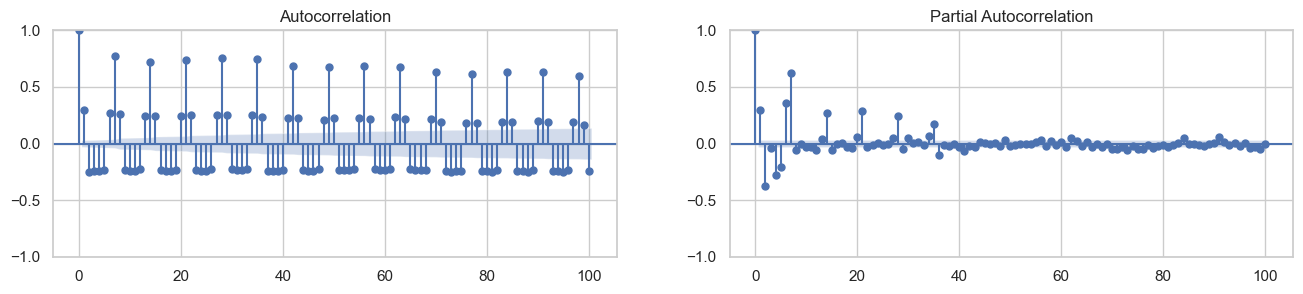

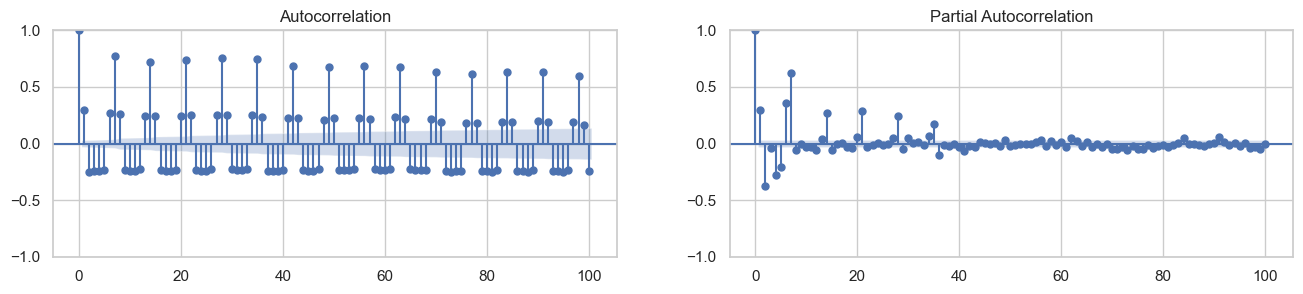

In [127]:
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data['total_passageiros'].values, lags=100, ax=axes[0])
plot_pacf(data['total_passageiros'].values, lags=100, ax=axes[1])

### Visualização dos dados

total_passageiros
feriado


<Figure size 432x288 with 0 Axes>

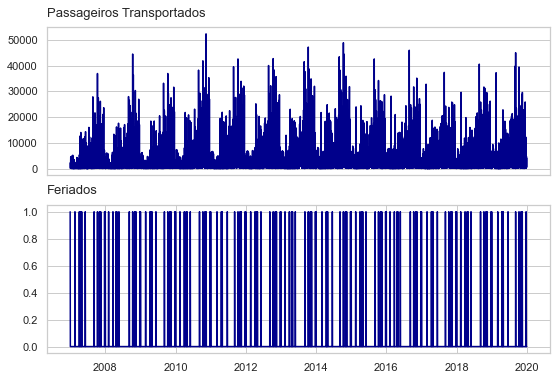

In [347]:
from turtle import color


def plot_series(data, axis_x, titles):
    dataset = pd.DataFrame(data.values)
    groups = dataset.columns
    column_names = data.columns
    i = 1
    fig = plt.figure()
    fig.tight_layout()
    plt.figure(figsize=(9, 6));
    plt.subplots_adjust(hspace = 0.2)
    for group in groups:
        print(column_names[group])
        plt.subplot(len(groups), 1, i, )
        if column_names[group] != 'feriado':
            plt.xticks([])
        else:
            plt.xticks(rotation=0)    
        plt.plot(pd.to_datetime(axis_x), data.values[:, group], color='darkblue')
        
        plt.title(titles[column_names[group]], loc='left', pad=20, va='top', fontsize=13)
        i += 1
        
    plt.show()
titles = {'total_passageiros': 'Passageiros Transportados',  'feriado': 'Feriados'}
plot_series(data[['total_passageiros', 'feriado']], data.index.values, titles)

In [129]:
def plotseasonal(res, fontsize, color, title, xlabel):
    plt.rc('figure',figsize=(12,8))
    plt.rc('font',size=15)    
    title_style = {'fontsize': 24, 'fontweight': 'bold', 'fontname': 'Arial', 'loc':'left'}
    axis_style = {'family': 'normal', 'size': fontsize}
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
    plt.rc('font', **axis_style)    
    fig.suptitle("\n".join([title]), y=1,**title_style)
    fig.patch.set_facecolor('white')
    sns.set(style="whitegrid")
    res.observed.plot(ax=axes[0], legend=False, color=color)
    axes[0].set_ylabel('observado', fontsize = fontsize)
    res.trend.plot(ax=axes[1], legend=False, color=color)
    axes[1].set_ylabel('tendência', fontsize = fontsize)
    res.seasonal.plot(ax=axes[2], legend=False, color=color)
    axes[2].set_ylabel('sazonalidade', fontsize = fontsize)
    res.resid.plot(ax=axes[3], legend=False, color=color)
    axes[3].set_ylabel('resíduo', fontsize = fontsize)
    axes[3].set_xlabel(xlabel, fontsize = fontsize)
    plt.tight_layout()

    plt.show()

    # plt.savefig(output_folder + file_name, pad_inches=0.2)
    plt.close()    

#### - decomposição temporal

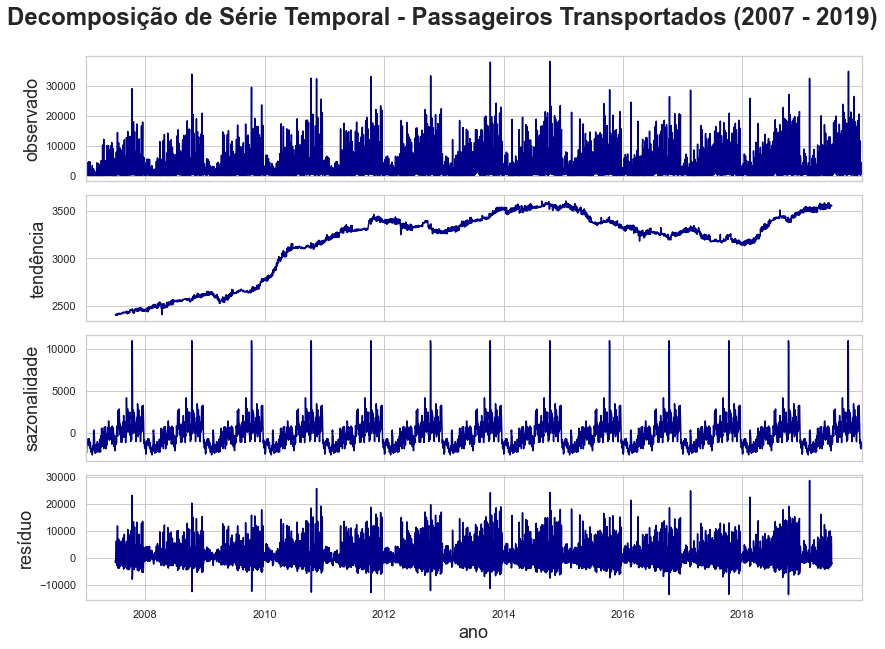

In [130]:
# ---------------------------------------------------------------------------
title = "Decomposição de Série Temporal\nPassageiros Transportados (2007 - 2019)"
# file_name = "decomp_timeseries" +".png"
fontsize = 18 

decompfreq = 7  # sazonalidade em períodos
trend_extrapolation = 1  # extrapolação dos dados de tendência
graph_color = 'darkblue'
# ---------------------------------------------------------------------------

result = sm.tsa.seasonal_decompose(data.total_passageiros, period=365, model='additive')
plotseasonal(result, fontsize, graph_color, title, 'ano')


In [131]:
df_residuos = result.resid.dropna()

#### Resíduo

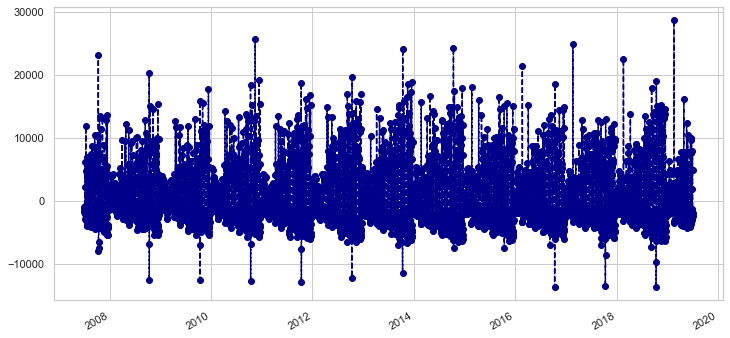

In [132]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
fig, ax = plt.subplots()
x = df_residuos.index
y = df_residuos.values
ax.plot_date(x, y, color='darkblue', linestyle='--')
# ax.annotate('Anomaly', (mdates.date2num(x[35]), y[35]), xytext=(30, 20),
#           textcoords='offset points', color='red',arrowprops=dict(facecolor='red',arrowstyle='fancy'))
fig.autofmt_xdate()
plt.show()

In [133]:
stat, p = shapiro(df_residuos.values)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=0.843, p=0.000
Probably not Gaussian


In [134]:
# Example of the Augmented Dickey-Fuller unit root test
stat, p, lags, obs, crit, t = \
	adfuller(df_residuos.values)

print('stat=%.3f, p=%.3f' % (stat, p))
print('ADF Statistic: %f' % stat)
print('p-value: %f' % p)
print('Critical Values:')
for key, value in crit.items():
	print('\t%s: %.3f' % (key, value))

if p > 0.05:
	print('Probably not Stationary')
else:
	print('Probably Stationary')

stat=-10.804, p=0.000
ADF Statistic: -10.804335
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Probably Stationary


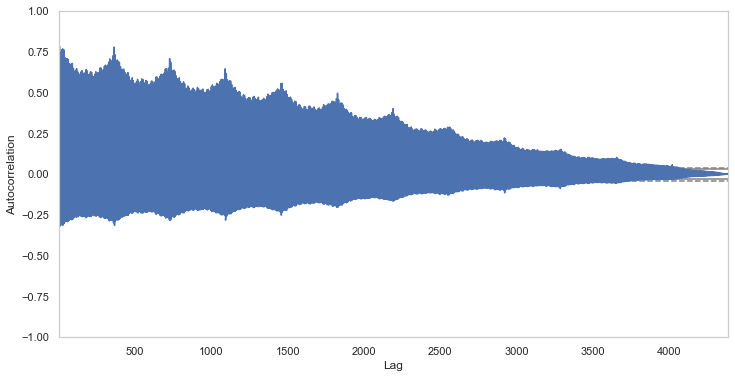

In [135]:
# residuals = DataFrame(residuals)
autocorrelation_plot(df_residuos)
plt.show()

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([-0.31855733, -0.30036866,  0.23495067,  0.78600626,  0.23681039,
        -0.31963303, -0.32682617, -0.33610903, -0.34992491,  0.23862869,
         1.        ,  0.23862869, -0.34992491, -0.33610903, -0.32682617,
        -0.31963303,  0.23681039,  0.78600626,  0.23495067, -0.30036866,
        -0.31855733]),
 <matplotlib.lines.Line2D at 0x1820cce5c70>)

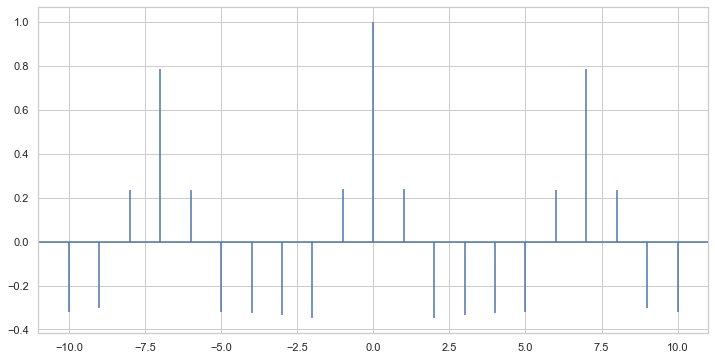

In [136]:
# Plotting the Autocorrelation plot.
plt.acorr(df_residuos, maxlags = 10)

##### Dickey-Fuller 

In [137]:
# periods = np.arange(1, 365)
periods = np.array([1, 7, 52, 30, 365])

In [138]:
stat = []
pvalue = []
lags =[]
obs = []
crit = []
t_test = []
for p in periods:
    results_sd = \
        sm.tsa.seasonal_decompose(data.total_passageiros, period=p, model='additive')
    s1, p1, l1, o1, c1, t1 = adfuller(results_sd.resid.dropna())
    results_sd = \
        sm.tsa.seasonal_decompose(data.total_passageiros, period=p, model='multiplicative')
    s2, p2, l2, o2, c2, t2 = adfuller(results_sd.resid.dropna())
    stat.append([s1, s2])
    pvalue.append([p1, p2])
    lags.append([l1, l2])
    obs.append([o1, o2])
    crit.append([c1, c2])
    t_test.append([t1, t2])
    print(f"periodo: {p}")

periodo: 1
periodo: 7
periodo: 52
periodo: 30
periodo: 365


In [139]:
# teste = np.array(pvalue)
# teste[:, 0][:]

df_pvalue = pd.DataFrame(pvalue)
df_pvalue['period'] = periods
df_pvalue.set_index('period', inplace=True)
df_pvalue

,0,1
period,,
1,NaN,NaN
7,0.000000e+00,0.000000e+00
52,0.000000e+00,2.172906e-30
30,0.000000e+00,0.000000e+00
365,1.980891e-19,1.407787e-09


In [140]:
def plot_values(values, xvalues, titles):
    # print(label)
    # for v in values:
        # print(l, f)
    plt.plot(xvalues, values[:, 0])
    # plt.plot(xvalues, values[:, 1])
    # plt.plot(history.history['val_' + f], label='validation ' + f)
    plt.title(titles)
    plt.legend()        
    plt.show()

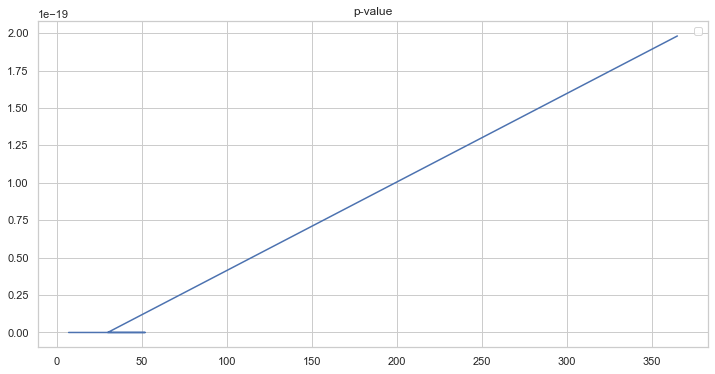

In [141]:
plot_values(np.array(pvalue), periods, 'p-value')

In [142]:
# Example of the Augmented Dickey-Fuller unit root test
stat, p, lags, obs, crit, t = \
	adfuller(df_residuos.values)

print('stat=%.3f, p=%.3f' % (stat, p))
print('ADF Statistic: %f' % stat)
print('p-value: %f' % p)
print('Critical Values:')
for key, value in crit.items():
	print('\t%s: %.3f' % (key, value))

if p > 0.05:
	print('Probably not Stationary')
else:
	print('Probably Stationary')

stat=-10.804, p=0.000
ADF Statistic: -10.804335
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Probably Stationary


In [143]:
# # !pip install pycaret
# plt.rc('figure',figsize=(9,6))
# plt.rc('font',size=15)
# fig, ax = plt.subplots()
# x = result.resid.index
# y = result.resid.values
# ax.boxplot(data['total_passageiros'])
# # ax.annotate('Anomaly', (mdates.date2num(x[35]), y[35]), xytext=(30, 20),
# #           textcoords='offset points', color='red',arrowprops=dict(facecolor='red',arrowstyle='fancy'))
# fig.autofmt_xdate()
# plt.show()

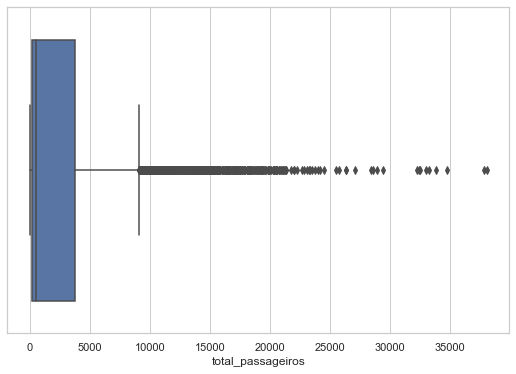

In [144]:
plt.rc('figure',figsize=(9, 6))
sns.set_theme(style="whitegrid")
# tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data["total_passageiros"], orient='v', showfliers = True)

In [145]:
## Relatório EDA
# import pandas_profiling as pp
# report = pp.ProfileReport(
#     load_dataset('../../dataset/raw/data_fret.csv')
# )
# report.to_file("../report/report.html")

In [146]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4748 entries, 2007-01-01 to 2019-12-31
Freq: D
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   total_passageiros  4748 non-null   int32
 1   feriado            4748 non-null   int64
 2   ano                4748 non-null   int64
 3   trimestre          4748 non-null   int64
 4   mes                4748 non-null   int64
 5   semana_do_ano      4748 non-null   int64
 6   dia_da_semana      4748 non-null   int64
 7   dia_do_mes         4748 non-null   int64
 8   dia_do_ano         4748 non-null   int64
dtypes: int32(1), int64(8)
memory usage: 352.4 KB


#### - Blox plot

In [147]:
plt.rc('figure',figsize=(12, 8))

In [148]:
"""# Prepare data
data['ano'] = [d.year for d in data.index]
data['mes'] = [d.strftime('%b') for d in data.index]
# data['semana'] = [d.weekday for d in data.index]
# data['semana'] = [d.strftime('%b') for d in data.index]
df_weekday = data
years = data['ano'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='ano', y='total_passageiros', data=data, ax=axes[0])
sns.boxplot(x='mes', y='total_passageiros', data=data.loc[~data.ano.isin([2007, 2019]), :])
# sns.boxplot(x='semana', y='total_passageiros', data=data)
# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18) 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
# axes[2].set_title('Week-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()
"""

"# Prepare data\ndata['ano'] = [d.year for d in data.index]\ndata['mes'] = [d.strftime('%b') for d in data.index]\n# data['semana'] = [d.weekday for d in data.index]\n# data['semana'] = [d.strftime('%b') for d in data.index]\ndf_weekday = data\nyears = data['ano'].unique()\n\n# Draw Plot\nfig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)\nsns.boxplot(x='ano', y='total_passageiros', data=data, ax=axes[0])\nsns.boxplot(x='mes', y='total_passageiros', data=data.loc[~data.ano.isin([2007, 2019]), :])\n# sns.boxplot(x='semana', y='total_passageiros', data=data)\n# Set Title\naxes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18) \naxes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)\n# axes[2].set_title('Week-wise Box Plot\n(The Seasonality)', fontsize=18)\nplt.show()\n"

In [149]:
def plot_bar(data, params):
    title = params['title']
    # file_path = "C:/Users/Acer/Desktop/temp/img/output/"
    # file_name = "barras" +".png"

    # Make a fake dataset:
    # data = [3, 12, 5, 18, 45]
    # labels = ('A', 'B', 'C', 'D', 'E')
    # data = params['series']  # data["viagens"]
    labels = params['title']  # data["dia_da_semana"]
    y_pos = np.arange(len(labels))
    
    # Create bars
    # ax = plt.axes()
    # ax.set_axisbelow(True)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    plt.bar(y_pos, data, align='center', alpha=0.5, color='green', edgecolor="darkgreen", linewidth=2)
    plt.xticks(y_pos, labels, rotation=90)



    # ax.tick_params(colors='gray', direction='out')
    # plt.grid(bcolor = 'lightgrey')
    # Change outer background color
    # plt.rcParams['figure.facecolor'] = 'lightgrey'
    # plt.figure(facecolor=(1, 1, 1))

    plt.margins(0.2)    

In [150]:
# label = pd.DataFrame([d.strftime('%b') for d in data.index]).unique()
# label

In [151]:
df_plot = data
df_plot['ano'] = [d.year for d in df_plot.index]
# data['mes'] = [d.strftime('%b') for d in data.index]
# data['semana'] = [d.weekday for d in data.index]
# data['semana'] = [d.strftime('%b') for d in data.index]
# df_weekday = data
label = df_plot['ano'].unique()
params = {
    'title': 'Barras',
    'label': label}
# plot_bar(data['total_passageiros'], params)

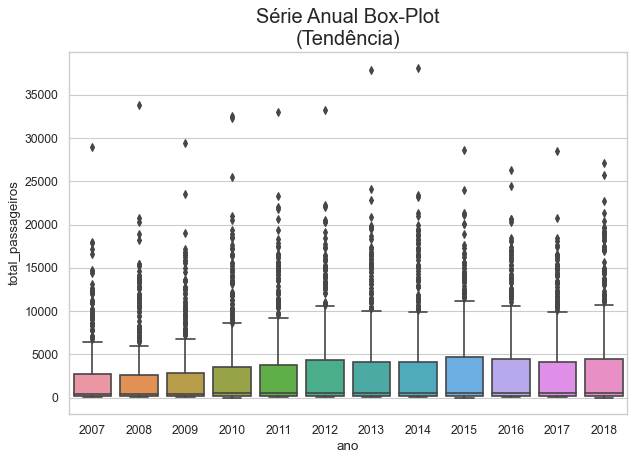

In [152]:
figsize = (9, 6) # Prepare data
data['ano'] = [d.year for d in data.index]
# data['mes'] = [d.strftime('%b') for d in data.index]
# data['semana'] = [d.weekday for d in data.index]
# data['semana'] = [d.strftime('%b') for d in data.index]
df_weekday = data
years = data['ano'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 1, figsize=figsize, dpi= 80)
sns.boxplot(x='ano', y='total_passageiros', data=df_weekday.loc[~data.ano.isin([2006, 2019]), :])
# sns.boxplot(x='mes', y='total_passageiros', data=data.loc[~data.ano.isin([2007, 2019]), :])
# sns.boxplot(x='semana', y='total_passageiros', data=data)
# Set Title
axes.set_title('Série Anual Box-Plot\n(Tendência)', fontsize=18) 
# axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
# axes[2].set_title('Week-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

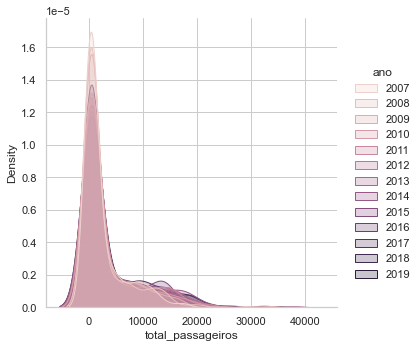

In [153]:
sns.displot(data[["ano", "total_passageiros"]], hue='ano', x='total_passageiros', kind="kde", fill=True)

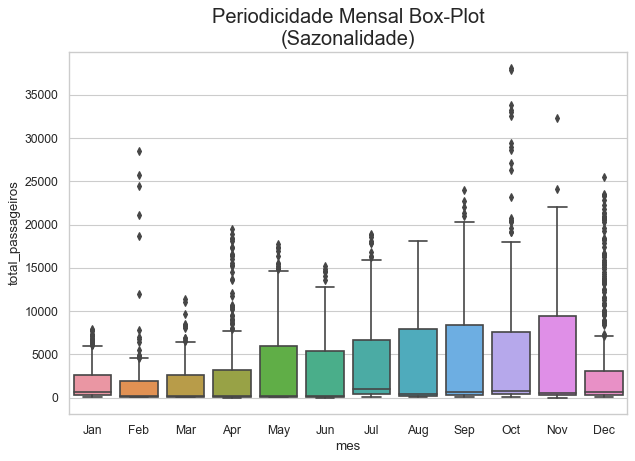

In [154]:
# Prepare data
# data['ano'] = [d.year for d in data.index]
data['mes'] = [d.strftime('%b') for d in data.index]
# data['semana'] = [d.weekday for d in data.index]
# data['semana'] = [d.strftime('%b') for d in data.index]
df_weekday = data
# years = data['ano'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 1, figsize=figsize, dpi= 80)
# sns.boxplot(x='ano', y='total_passageiros', data=data, ax=axes[0])
sns.boxplot(x='mes', y='total_passageiros', data=df_weekday.loc[~data.ano.isin([2006, 2019]), :])
# sns.boxplot(x='semana', y='total_passageiros', data=data)
# Set Title
# axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18) 
axes.set_title('Periodicidade Mensal Box-Plot\n(Sazonalidade)', fontsize=18)
# axes[2].set_title('Week-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

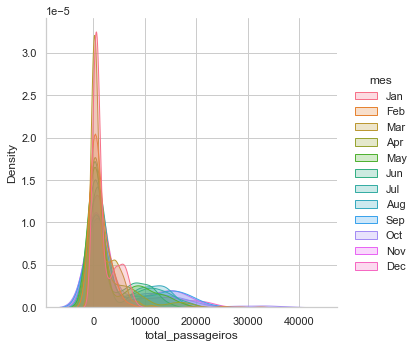

In [155]:
sns.displot(data[["mes", "total_passageiros"]], hue='mes', x='total_passageiros', kind="kde", fill=True)

In [156]:
data.head()

,total_passageiros,feriado,ano,trimestre,mes,semana_do_ano,dia_da_semana,dia_do_mes,dia_do_ano
data_ref,,,,,,,,,
2007-01-01,1946,1,2007,1,Jan,1,0,1,1
2007-01-02,89,0,2007,1,Jan,1,1,2,2
2007-01-03,135,0,2007,1,Jan,1,2,3,3
2007-01-04,182,0,2007,1,Jan,1,3,4,4
2007-01-05,287,0,2007,1,Jan,1,4,5,5


In [157]:
df_week = data[['dia_da_semana']]
# df_week['semana'] = df_week.index.day_of_week
# df_week.drop(columns=['feriado', 'ano', 'trimestre', 'mes', 'semana', 'weekday'], inplace=True)
# df_week.head()

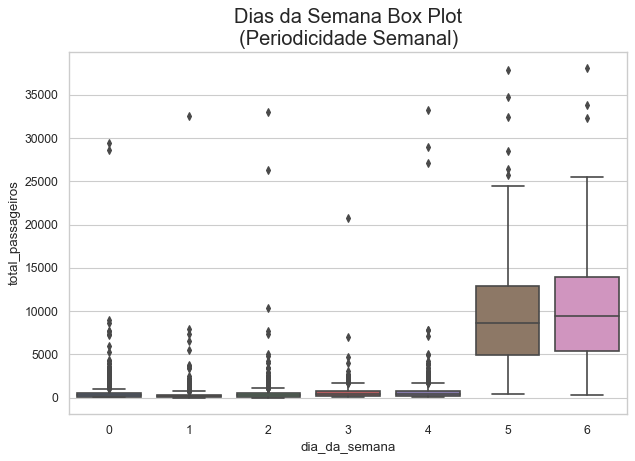

In [158]:
# Prepare data
# data['ano'] = [d.year for d in data.index]
# data['mes'] = [d.strftime('%b') for d in data.index]
# data['semana'] = [d.weekday for d in data.index]
# data['semana'] = [d.strftime('%b') for d in data.index]
# df_weekday = data
# years = data['ano'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 1, figsize=figsize, dpi= 80)
sns.boxplot(x='dia_da_semana', y='total_passageiros', data=data)
# sns.boxplot(x='mes', y='total_passageiros', data=data.loc[~data.ano.isin([2007, 2019]), :])
# sns.boxplot(x='semana', y='total_passageiros', data=data)
# Set Title
axes.set_title('Dias da Semana Box Plot\n(Periodicidade Semanal)', fontsize=18) 
# axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
# axes[2].set_title('Week-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

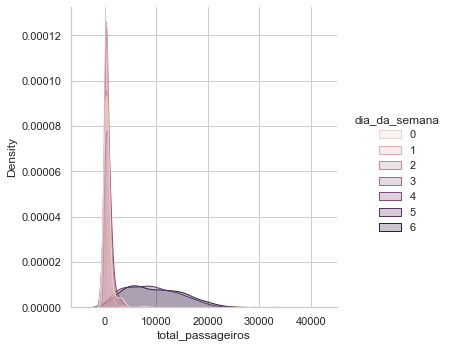

In [159]:
sns.displot(data[["dia_da_semana", "total_passageiros"]], hue='dia_da_semana', x='total_passageiros', kind="kde", fill=True)

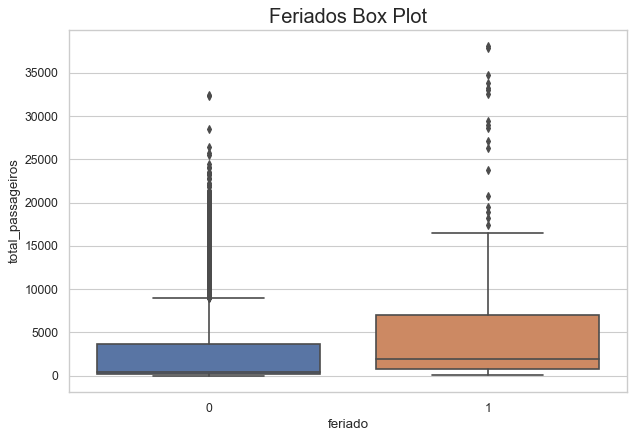

In [160]:
# Prepare data
# data['ano'] = [d.year for d in data.index]
# data['mes'] = [d.strftime('%b') for d in data.index]
# data['semana'] = [d.weekday for d in data.index]
# data['semana'] = [d.strftime('%b') for d in data.index]
# df_weekday = data
# years = data['ano'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 1, figsize=figsize, dpi= 80)
sns.boxplot(x='feriado', y='total_passageiros', data=data)
# sns.boxplot(x='mes', y='total_passageiros', data=data.loc[~data.ano.isin([2007, 2019]), :])
# sns.boxplot(x='semana', y='total_passageiros', data=data)
# Set Title
axes.set_title('Feriados Box Plot', fontsize=18) 
# axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
# axes[2].set_title('Week-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

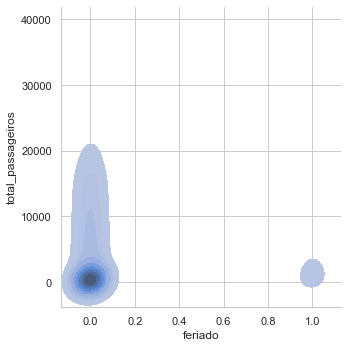

In [161]:
sns.displot(data[["feriado", "total_passageiros"]], x="feriado", y="total_passageiros", kind="kde", fill=True)

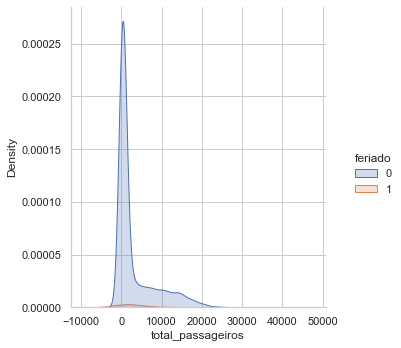

In [162]:
sns.displot(data[["feriado", "total_passageiros"]], hue='feriado', x='total_passageiros', kind="kde", fill=True)

In [163]:
feriados = data['total_passageiros'][data['feriado'] == 1].values
nao_feriados = data['total_passageiros'][data['feriado'] == 0].\
    sample(n=len(feriados), replace=False, random_state=RANDOM_SEED).\
        values
print(type(feriados))
print(type(nao_feriados))
# nao_feriados = nao_feriados.vakyes
# nao_feriados = data['total_passageiros'][data['feriado'] == 0].values

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [164]:
sampling_difference = nao_feriados - feriados

shapiro(sampling_difference)

ShapiroResult(statistic=0.8423915505409241, pvalue=1.155891354853722e-11)

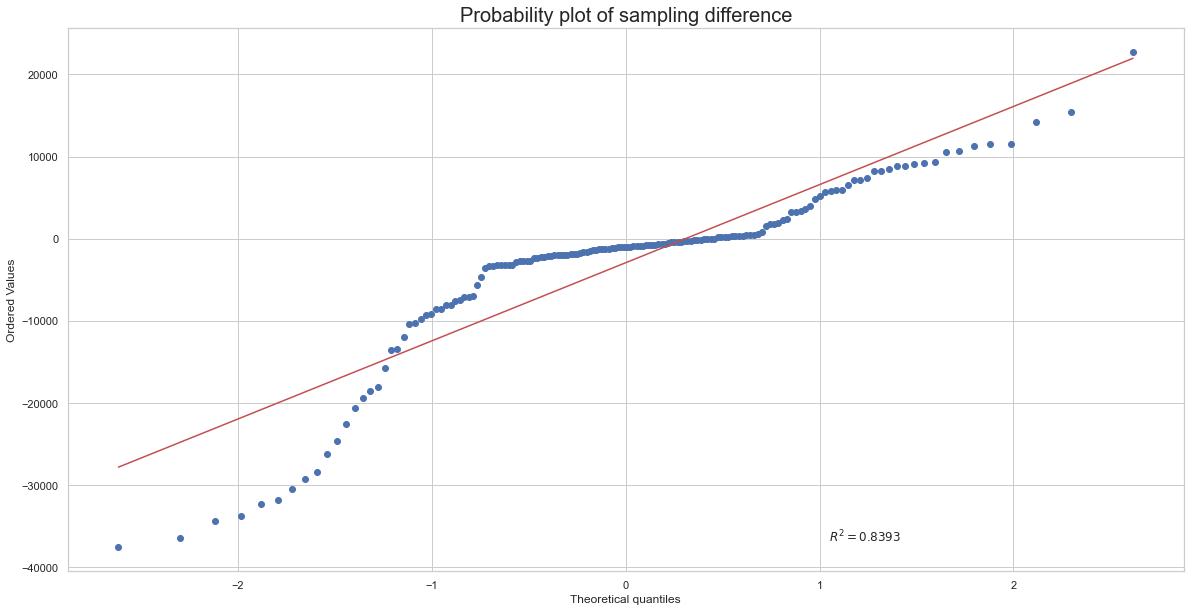

In [165]:
fig = plt.figure(figsize= (20, 10))
ax = fig.add_subplot(111)

normality_plot, stat = probplot(sampling_difference, plot= plt, rvalue= True)
ax.set_title("Probability plot of sampling difference", fontsize= 20)
ax.set

plt.show()

In [166]:
# summary, results = rp.ttest(
#     group1=feriados, group1_name='feriados',
#     group2=nao_feriados, group2_name='nao_feriados')
# print(summary)

In [167]:
# print(results)

In [168]:
ttest_ind(feriados, nao_feriados)

Ttest_indResult(statistic=3.648602094926137, pvalue=0.00030926022146516484)

In [169]:
_, pnorm = mannwhitneyu(nao_feriados, feriados, use_continuity=False,
                        method="asymptotic")
print(pnorm)                        

4.2734302791301653e-07


In [170]:
result = mannwhitneyu(nao_feriados, feriados, use_continuity=False,
                        method="asymptotic")
print(result)                        

MannwhitneyuResult(statistic=8139.5, pvalue=4.2734302791301653e-07)


In [171]:
stat, p = shapiro(data['total_passageiros'][data['feriado'] == 1].values)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')
	
stat, p = shapiro(data['total_passageiros'][data['feriado'] == 0].values)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')


stat=0.634, p=0.000
Probably not Gaussian
stat=0.651, p=0.000
Probably not Gaussian


HOMOGENEITY OF VARIANCE
One of the assumptions is that both groups have equal variances. One method for testing this assumption is the Levene's test of homogeneity of variances. This can be completed using the levene() method from Scipy.stats.

In [172]:
levene(feriados,
    nao_feriados,
    center= 'mean')

LeveneResult(statistic=27.228864583926963, pvalue=3.314869821735467e-07)

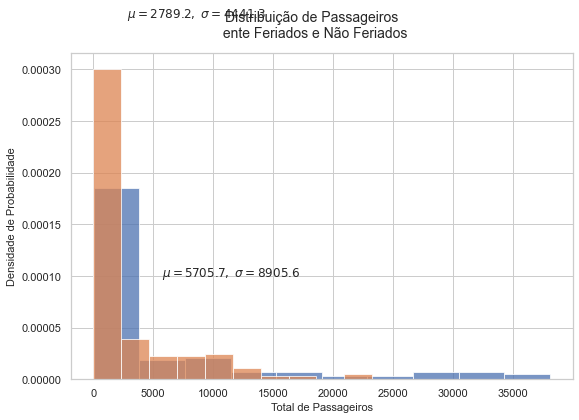

In [173]:
fig = plt.figure(figsize= (9, 6))
ax = fig.add_subplot(111)


p_bp_male = plt.hist(feriados, label= "feriados",
                     density= True,
                     alpha=0.75)
p_bp_female = plt.hist(nao_feriados, label= "nao feriados",
                       density= True,
                       alpha=0.75)


plt.suptitle("Distribuição de Passageiros \n ente Feriados e Não Feriados", fontsize= 14)
plt.xlabel("Total de Passageiros", fontsize= 11)
plt.ylabel("Densidade de Probabilidade", fontsize= 11)

plt.text(2800, .00035,
         f"$\mu= {nao_feriados.mean(): .1f}, \ \sigma= {nao_feriados.std(): .1f}$")
plt.text(5700, .0001,
         f"$\mu= {feriados.mean(): .1f}, \ \sigma= {feriados.std(): .1f}$")


plt.show()

#### Welch’s t-test

***WHAT IS IT?***

Welch’s t-test is a nonparametric univariate test that tests for a significant difference between the mean of two unrelated groups. It is an alternative to the independent t-test when there is a violation in the assumption of equality of variances.

The hypothesis being tested is:

* Null hypothesis (H0): u1 = u2, which translates to the mean of sample 1 is equal to the mean of sample 2
* Alternative hypothesis (HA): u1 ≠ u2, which translates to the mean of sample 1 is not equal to the mean of sample 2

If the p-value is less than what is tested at, most commonly 0.05, one can reject the null hypothesis.

***WELCH’S T-TEST ASSUMPTIONS***

Like every test, this inferential statistic test has assumptions. The assumptions that the data must meet in order for the test results to be valid are:

The independent variable (IV) is categorical with at least two levels (groups)

The dependent variable (DV) is continuous which is measured on an interval or ratio scale

The distribution of the two groups should follow the normal distribution

If any of these assumptions are violated then another test should be used.

In [174]:
#perform Welch's t-test 
results = ttest_ind(feriados, nao_feriados, equal_var = False)
results

Ttest_indResult(statistic=3.648602094926137, pvalue=0.00032695630102629324)

In [175]:
nao_feriados = data['total_passageiros'][data['feriado'] == 0].values

In [176]:
#perform Welch's t-test 
results = ttest_ind(feriados, nao_feriados, equal_var = False)
results

Ttest_indResult(statistic=3.6692126218807237, pvalue=0.0003319457262838382)

## 7. Preparação dos Dados para os Modelos de Aprendizado de Máquina

### Data Preparation

* > In this part, data is preprocessed with different processes.
* > I follow this order in preprocessing part :
* 1. reshape
* 2. change type
* 3. scalling
* 4. spliting train-test dataset
* 5. create dataset

* **Reshape and Change Type**

#### Treinamento e Teste

#### Treinamento, Validação e Teste

In [177]:
def train_test_split_custom(X_data, Y_data, val_size=0.1, test_size=0.1):
    data_size = len(Y_data)
    test_data_size = int(data_size*test_size)
    val_data_size = int(data_size*val_size)
    train_data_size = data_size - test_data_size - val_data_size

    train_y = Y_data[:train_data_size,]
    val_y = Y_data[train_data_size:(train_data_size + val_data_size),:] 
    # test_y = Y_data[(train_data_size + val_data_size):data_size,:] 
    test_y = Y_data[-test_data_size:,:] 

    train_X = X_data[:train_data_size,]
    val_X = X_data[train_data_size:(train_data_size + val_data_size),:]
    test_X = X_data[(train_data_size + val_data_size):data_size,:]

    return train_X, val_X, test_X, train_y, val_y, test_y


def series_to_supervised(dataframe, n_in=1, n_out=1, periodicidade='D'):
    columns = dataframe.columns
    periodicidade_dict = {'M': 12, 'W': int(365/7), 'D': 365}
    for col in columns:
        for i in range(n_in, 0, -1):
            if 'total_passageiros' in col:
                value = dataframe[col].mean()

            elif 'feriado' in col or 'doze_outubro' in col:
                value = dataframe[col].shift(periodicidade_dict[periodicidade]).iloc[dataframe[col].shape[0]-1]

            else:
                value = 0
            dataframe[col + '-1'] = dataframe[col].shift(i, fill_value=value)
        for i in range(0, n_out):
            if i != 0:
                if 'total_passageiros' in col:
                    value = dataframe[col].mean()
                      
                elif 'feriado' in col or 'doze_outubro' in col:
                    value = dataframe[col].shift(-periodicidade_dict[periodicidade]).iloc[0]
                else:
                    value = 0
            dataframe[col + '+1'] = dataframe[col].shift(-i, fill_value=value)                    

    return dataframe

    
def prepare_data(data, periodicidade='D', val_size=0.1, test_size=0.1):
    
    X_scaler = MinMaxScaler()
    Y_scaler = MinMaxScaler()
    

    X_data = series_to_supervised(data[['feriado', 'total_passageiros']], 1, 2, periodicidade) 
       
    X_data.drop(columns=['total_passageiros'], inplace=True)
    X_data = X_scaler.fit_transform(X_data)

    Y_data = Y_scaler.fit_transform(data[['total_passageiros']].values)  

    train_X, val_X, test_X, train_y, val_y, test_y = train_test_split_custom(
        X_data, Y_data, val_size, test_size)

    train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
    val_X = np.reshape(val_X, (val_X.shape[0], val_X.shape[1], 1))
    test_X = np.reshape(test_X, (test_X.shape[0],test_X.shape[1], 1))
        
    return train_X, val_X, test_X, train_y, val_y, test_y, X_scaler, Y_scaler


In [178]:
train_X, val_X, test_X, train_y, val_y, test_y, X_scaler, Y_scaler = \
    prepare_data(data, periodicidade, val_size=0.1, test_size=0.1)

In [179]:
# print(np.any(np.isnan(test_X)))
# print(np.any(np.isnan(test_y)))
# print(np.any(np.isnan(train_X)))
# print(np.any(np.isnan(train_y)))

# **MÓDULO C4**

## Implementing Models

* **Modelo RNN Simples**

In [180]:
metric_list=['mse', 'mae', 'mape']
epochs = 200

In [181]:
def build_vanilla_rnn_model(input_size, metric_list):
    
    # Initializing RNN
    model = Sequential()
    # Add the first layer and Dropout regularization
    model.add(SimpleRNN(
        units=100, activation='tanh', return_sequences=True,
        input_shape=(input_size, 1)))
    # model.add(Dropout(0.20))
    # # Second layer and Dropout regularization
    # model.add(SimpleRNN(
    #     units = 100, activation='tanh', return_sequences=True))
    # model.add(Dropout(0.20))
    # # Third layer and Dropout regularization
    # model.add(SimpleRNN(
    #     units = 70, activation='tanh', return_sequences= True))
    # model.add(Dropout(0.20))
    # # Fourth layer and Dropout regularization
    # model.add(SimpleRNN(units = 50))
    # model.add(Dropout(0.20))
    # Add final or output layer
    model.add(Dense(units=1))
    
    print(f"{model.summary()}")

    # model.compile(optimizer='adam', loss='mean_squared_error')
    adam = Adam(lr=0.0001)
    model.compile(
        loss='mse',
        optimizer=adam,
        metrics=metric_list)
    
    return model 


# Remember epochs, batch_size etc. are just some of hyper parameters. 
# You can change these parameters whatever you want

In [182]:
metric_list=['mse', 'mae', 'mape']
epochs = 1000
early_stopings = callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')

In [183]:
model_path = "../models/fret_vanilla_rnn.h5"
checkpoint =  callbacks.ModelCheckpoint(
    model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callback_list=[early_stopings, checkpoint] 


In [184]:
rnn_model = build_vanilla_rnn_model(train_X.shape[1], metric_list)
print(train_X.shape)
# history_rnn = rnn_model.fit(train_X, train_y, epochs, batch_size=32)
history_rnn = rnn_model.fit(
    train_X, train_y,
    epochs=epochs,
    batch_size=32,
    validation_data=(val_X, val_y),
    verbose=1,
    shuffle=False,
    callbacks=callback_list)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 5, 100)            10200     
_________________________________________________________________
dense_1 (Dense)              (None, 5, 1)              101       
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________
None
(3800, 5, 1)
Epoch 1/1000
119/119 [==============================] - 1s 5ms/step - loss: 0.0187 - mse: 0.0187 - mae: 0.0944 - mape: 1403.5222 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1029 - val_mape: 165851.8438
Epoch 2/1000
119/119 [==============================] - 0s 2ms/step - loss: 0.0177 - mse: 0.0177 - mae: 0.0974 - mape: 1672.1018 - val_loss: 0.0174 - val_mse: 0.0174 - val_mae: 0.1030 - val_mape: 162501.6094
Epoch 3/1000
119/119 [==============================] - 0s 2ms/step - loss: 0.

In [185]:
# %pip install pydot

In [186]:
# plot_model(rnn_model)

In [187]:
# rnn_model = build_vanilla_rnn_model(train_X.shape[1], metric_list)
# print(train_X.shape)
# # history_rnn = rnn_model.fit(train_X, train_y, epochs, batch_size=32)
# history_rnn = rnn_model.fit(
#     train_X, train_y,
#     epochs=epochs, batch_size=32, validation_data=(val_X, val_y), verbose=0, shuffle=False)

* **Modelo LSTM**

In [188]:
def build_lstm_model(input_size, metric_list, unit=50):

    model = Sequential()
    model.add(LSTM(unit, input_shape=(input_size[1], input_size[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=metric_list)

    print(f"{model.summary()}")

    return model 

In [189]:
model_path = "../models/fret_lstm.h5"
checkpoint =  callbacks.ModelCheckpoint(
    model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callback_list=[early_stopings, checkpoint] 

In [190]:
lstm_model = build_lstm_model(train_X.shape, metric_list, 50)

history_lstm = lstm_model.fit(
    train_X, train_y,
    epochs=epochs, 
    batch_size=64,
    validation_data=(val_X, val_y),
    verbose=1,
    shuffle=False,
    callbacks=callback_list)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
60/60 [==============================] - 2s 12ms/step - loss: 0.0170 - mse: 0.0170 - mae: 0.0953 - mape: 1571.7230 - val_loss: 0.0163 - val_mse: 0.0163 - val_mae: 0.0992 - val_mape: 131062.2969
Epoch 2/1000
60/60 [==============================] - 0s 4ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0913 - mape: 1515.6235 - val_loss: 0.0155 - val_mse: 0.0155 - val_mae: 0.0961 - val_mape: 111904.8672
Epoch 3/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.0153 - mse: 0.0153

In [191]:
# lstm_model = build_lstm_model(train_X.shape, metric_list, 50)

# history_lstm = lstm_model.fit(
#     train_X, train_y,
#     epochs=epochs, batch_size=64, validation_data=(val_X, val_y), verbose=0, shuffle=False)

In [192]:
print(history_lstm.history.keys())
print(history_lstm.params)

dict_keys(['loss', 'mse', 'mae', 'mape', 'val_loss', 'val_mse', 'val_mae', 'val_mape'])
{'verbose': 1, 'epochs': 1000, 'steps': 60}


* **GRU**

In [193]:
def build_gru_model(units, input_size, metric_list):
    # Create GRU model
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [input_size[1], input_size[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam', loss='mse', metrics=metric_list)
    
    return model


In [194]:
model_path = "../models/fret_gru.h5"
checkpoint =  callbacks.ModelCheckpoint(
    model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callback_list=[early_stopings, checkpoint] 

In [195]:
gru_model = build_gru_model(64, train_X.shape, metric_list)
history_gru = gru_model.fit(
    train_X, train_y,
    epochs=epochs, 
    batch_size=64,
    validation_data=(val_X, val_y),
    verbose=1,
    shuffle=False,
    callbacks=callback_list)
    # epochs=epochs, batch_size=64, validation_data=(test_X, test_y), verbose=0, shuffle=False)

Epoch 1/1000
60/60 [==============================] - 5s 21ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0900 - mape: 1439.3317 - val_loss: 0.0146 - val_mse: 0.0146 - val_mae: 0.0855 - val_mape: 45426.7969
Epoch 2/1000
60/60 [==============================] - 0s 8ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0801 - mape: 1139.4781 - val_loss: 0.0142 - val_mse: 0.0142 - val_mae: 0.0863 - val_mape: 46632.4141
Epoch 3/1000
60/60 [==============================] - 0s 8ms/step - loss: 0.0144 - mse: 0.0144 - mae: 0.0794 - mape: 1150.0422 - val_loss: 0.0141 - val_mse: 0.0141 - val_mae: 0.0859 - val_mape: 44904.2695
Epoch 4/1000
60/60 [==============================] - 1s 9ms/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0785 - mape: 1065.5177 - val_loss: 0.0138 - val_mse: 0.0138 - val_mae: 0.0849 - val_mape: 43228.3047
Epoch 5/1000
60/60 [==============================] - 0s 8ms/step - loss: 0.0139 - mse: 0.0139 - mae: 0.0769 - mape: 1000.3226 - val_loss: 0.0134 - val_mse: 0.0134 - val_mae: 0.07

In [196]:
# gru_model = build_gru_model(64, train_X.shape, metric_list)
# history_gru = gru_model.fit(
#     train_X, train_y,
#     epochs=epochs, batch_size=64, validation_data=(val_X, val_y), verbose=0, shuffle=False)

In [197]:
# print(history_gru.history.keys())
# print(history_gru.params)

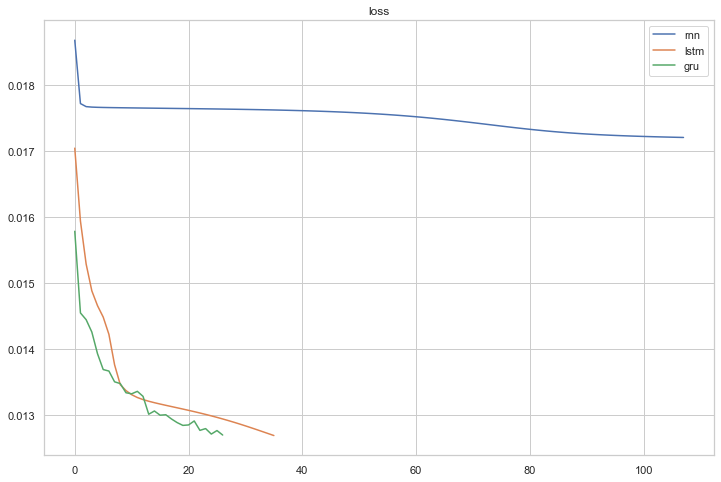

In [198]:
def plot_history(history, label, loss_field='loss'):
    for i in range(len(history)):
        plt.plot(history[i].history[loss_field], label=label[i])
        plt.title(loss_field)
        # plt.plot(h.history['val_loss'], label='test')
    plt.legend()
    plt.show()
# history = [history_rnn, history_lstm, history_gru, history_bilstm]
history = [history_rnn, history_lstm, history_gru]
# label = ['rnn', 'lstm', 'gru', 'bilstm']
label = ['rnn', 'lstm', 'gru']
# plot_history(history, label, loss_field='loss')
plot_history(history, label, loss_field='loss')


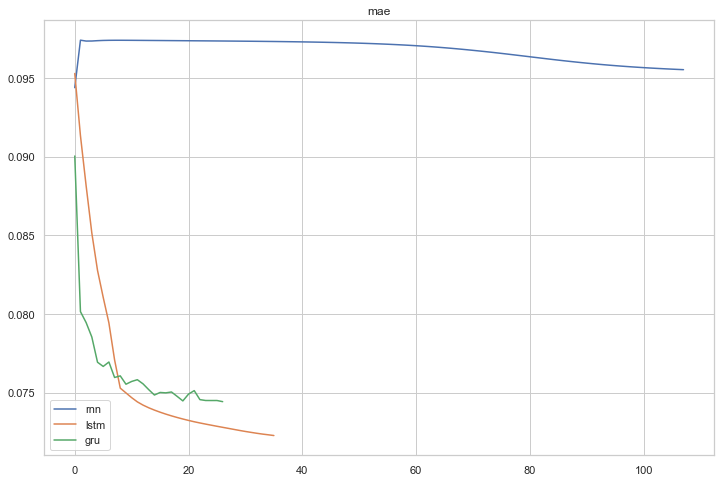

In [199]:
plot_history(history, label, loss_field='mae')


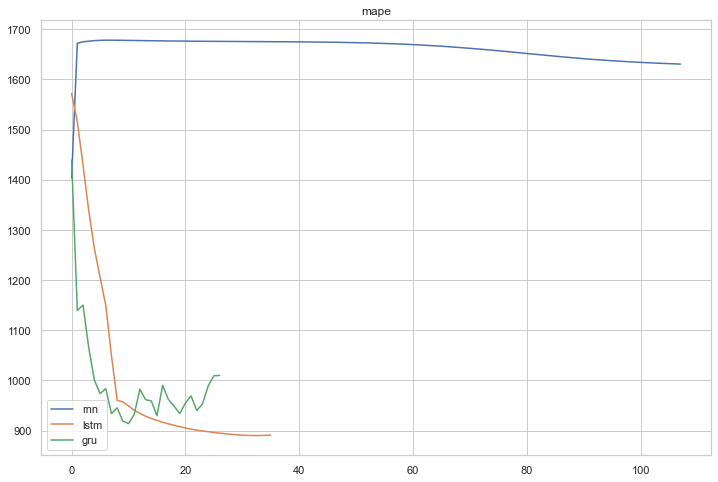

In [200]:
plot_history(history, label, loss_field='mape')

In [201]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()


In [202]:
def plot_history(history, label, fields=['loss', 'mse', 'mae', 'mape']):
    # print(label)
    for f in fields:
        # print(l, f)
        plt.plot(history.history[f], label='training ' + f)
        plt.plot(history.history['val_' + f], label='validation ' + f)
        plt.title(label.upper())
    plt.legend()        
    plt.show()

In [203]:
# history

3 3


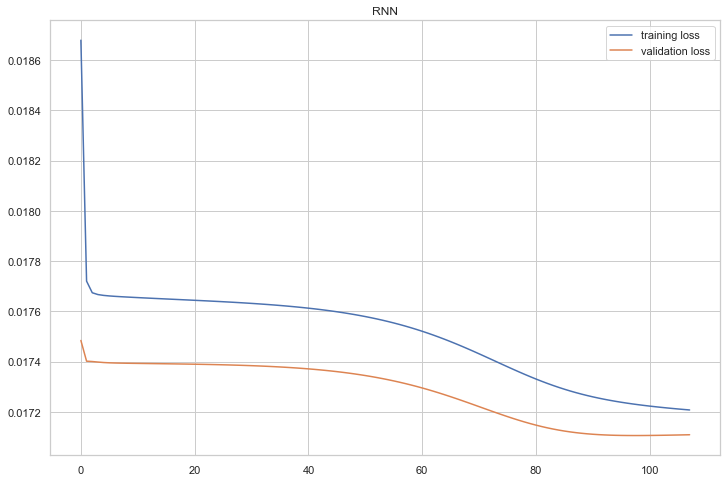

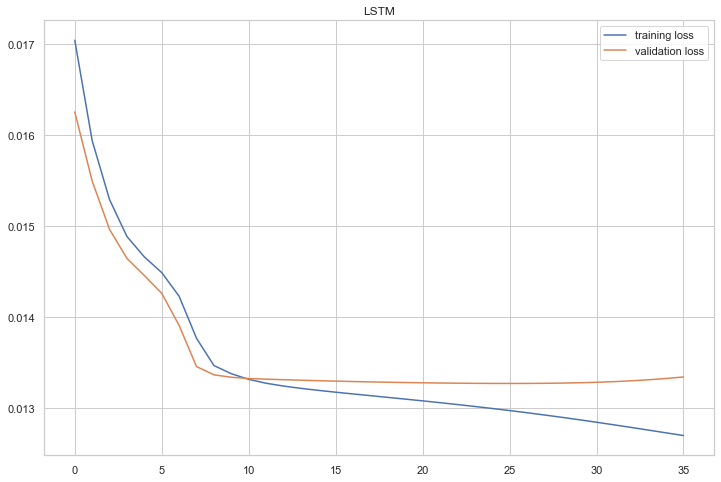

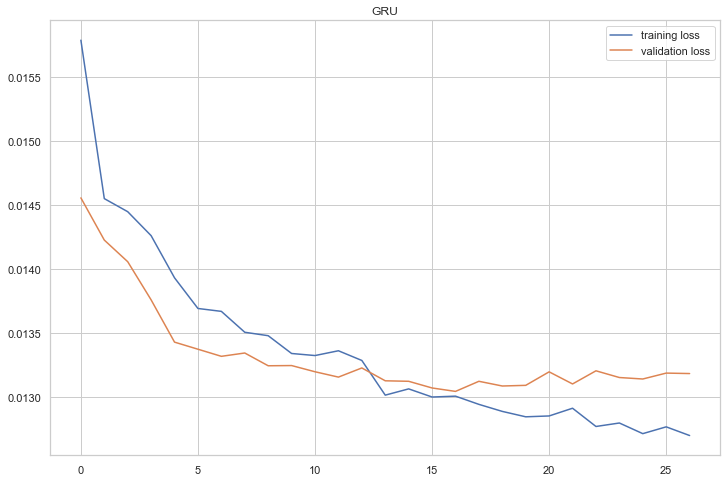

In [204]:
print(len(label), len(history))
for l, h in zip(label, history):
    plot_history(h, l, ['loss'])

## Predictions and Visualising RNN Model

In [205]:
def predict(model, train_X, train_y, val_X, val_y, test_X, test_y, Y_scaler):

    # Training
    # make a prediction
    trainPrediction = model.predict(train_X)
    # print(trainPrediction[:10,])
    train_y = Y_scaler.inverse_transform(train_y).astype(int)
    # print(train_y[:10,])
    trainPrediction = Y_scaler.inverse_transform(trainPrediction).astype(int)
    # print(trainPrediction[:10,])
    ##################################################
    ##### TROCAR PELA MEDIA DO DIA DA SEMANA (MODULO DO INDICE)
    train_y[train_y<0] = np.mean(train_y, dtype=np.int64)
    trainPrediction[trainPrediction<0] = np.mean(train_y, dtype=np.int64)
    ##################################################

    # Validation
    valPrediction = model.predict(val_X)
    val_y = Y_scaler.inverse_transform(val_y).astype(int)
    valPrediction = Y_scaler.inverse_transform(valPrediction).astype(int)
    ##################################################
    ##### TROCAR PELA MEDIA DO DIA DA SEMANA (MODULO DO INDICE)
    val_y[val_y<0] = np.mean(val_y, dtype=np.int64)
    valPrediction[valPrediction<0] = np.mean(val_y, dtype=np.int64)
    ##################################################  

    # Test
    testPrediction = model.predict(test_X)
    test_y = Y_scaler.inverse_transform(test_y).astype(int)
    testPrediction = Y_scaler.inverse_transform(testPrediction).astype(int)
    ##################################################
    ##### TROCAR PELA MEDIA DO DIA DA SEMANA (MODULO DO INDICE)
    test_y[test_y<0] = np.mean(test_y, dtype=np.int64)
    testPrediction[testPrediction<0] = np.mean(train_y, dtype=np.int64)
    ##################################################    

    return train_y, val_y, test_y, trainPrediction, valPrediction, testPrediction
    

In [206]:
# inv_yhat, inv_y = predict(model, test_X, scaler)
train_y, val_y, test_y, trainPrediction, valPrediction, testPrediction = \
    predict(lstm_model, train_X, train_y, val_X, val_y, test_X, test_y, Y_scaler)

In [207]:
pd.DataFrame(valPrediction).describe()

,0
count,474.000000
mean,3518.409283
std,2908.924818
min,9.000000
25%,442.250000
50%,3451.500000
75%,6097.000000
max,13113.000000


In [208]:
# Showing graph
# filename = 'D:/OneDrive/Cursos/especializacao/01 - Disciplinas/16 - Projeto Integrado – Inteligência Artificial e Aprendizado de Máquina (2021)/prospecao/fretamento-antt/rnn_metodo2_model_1.png'
# show_model(model, filename)

#### Visualizando Predições

In [209]:
def plot_image(dataset, x_labels, trainPrediction, valPrediction, testPrediction):

    trainPredictPlot = np.full([dataset.shape[0], 1], np.nan)
    trainPredictPlot[:len(trainPrediction), :] = trainPrediction

    valPredictPlot = np.full([dataset.shape[0], 1], np.nan)
    valPredictPlot[len(trainPrediction):(len(trainPrediction)+len(valPrediction)), :] = valPrediction

    testPredictPlot = np.full([dataset.shape[0], 1], np.nan)
    testPredictPlot[-len(testPrediction):, :] = testPrediction

    plt.plot(pd.to_datetime(x_labels),
        dataset,
        label = 'True Values', color='blue')            
    plt.plot(pd.to_datetime(x_labels), trainPredictPlot, label='Train Prediction', color='red')
    plt.plot(pd.to_datetime(x_labels), valPredictPlot, label ='Validation Prediction', color='orange')
    plt.plot(pd.to_datetime(x_labels), testPredictPlot, label ='Test Prediction', color='green')
    
    plt.xlabel("tempo")
    plt.xticks(rotation=90)
    plt.ylabel("Número de Passageiros")
    plt.title("Transporte Fretado para Aparecida/SP")
    plt.legend()
    plt.show()

In [210]:
def plot_graph_2(dataset, x_labels, trainPrediction, valPrediction, testPrediction, window):

    trainPredictPlot = np.full([dataset.shape[0], 1], np.nan)
    trainPredictPlot[:len(trainPrediction), :] = trainPrediction
    trainPredictPlot = trainPredictPlot[window['start_pos']:window['end_pos']]

    valPredictPlot = np.full([dataset.shape[0], 1], np.nan)
    valPredictPlot[len(trainPrediction):(len(trainPrediction)+len(valPrediction)), :] = valPrediction
    valPredictPlot = valPredictPlot[window['start_pos']:window['end_pos']]

    testPredictPlot = np.full([dataset.shape[0], 1], np.nan)
    testPredictPlot[-len(testPrediction):, :] = testPrediction
    testPredictPlot = testPredictPlot[window['start_pos']:window['end_pos']]

    real_data = dataset[window['start_pos']:window['end_pos']]
    x_labels = x_labels[window['start_pos']:window['end_pos']]

    plt.plot(pd.to_datetime(x_labels),
        real_data,
        label = 'True Values', color='blue')            
    plt.plot(pd.to_datetime(x_labels), trainPredictPlot, label='Train Prediction', color='red')
    plt.plot(pd.to_datetime(x_labels), valPredictPlot, label ='Validation Prediction', color='orange')
    plt.plot(pd.to_datetime(x_labels), testPredictPlot, label ='Test Prediction', color='green')
    
    plt.xlabel("tempo")
    plt.xticks(rotation=90)
    plt.ylabel("Número de Passageiros")
    plt.title("Transporte Fretado para Aparecida/SP")
    plt.legend()
    plt.show()

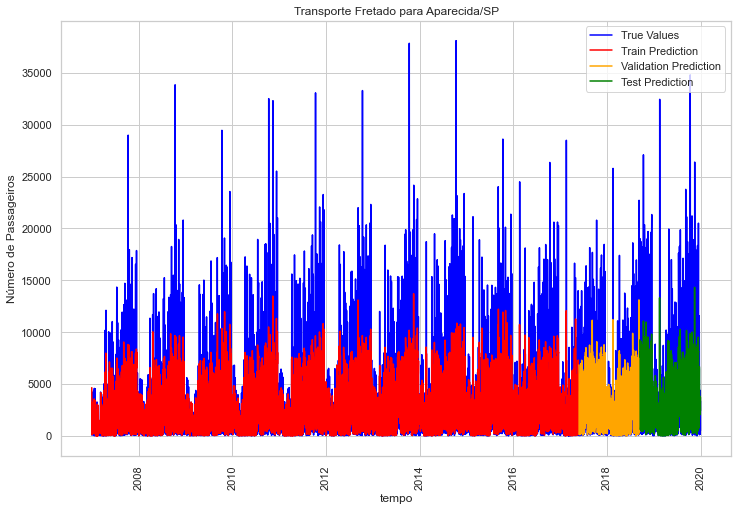

In [211]:
plot_image(data.iloc[:, 0].values, data.index.values, trainPrediction, valPrediction, testPrediction)

In [212]:
start_date = '2017-04-01'
end_date = '2017-09-30'
i = data[start_date:end_date].index.unique()
indexes = data.index.get_indexer_for(i)
window = {
    'start_pos': indexes[0],
    'end_pos': indexes[len(indexes)-1]
}

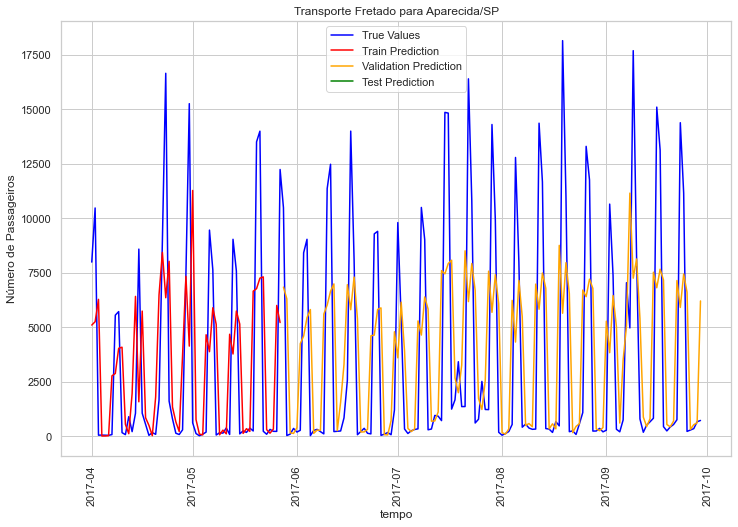

In [213]:
plot_graph_2(data.iloc[:, 0].values, data.index.values, trainPrediction, valPrediction, testPrediction, window)

In [214]:
start_date = '2018-07-01'
end_date = '2018-11-30'
i = data[start_date:end_date].index.unique()
indexes = data.index.get_indexer_for(i)
window = {
    'start_pos': indexes[0],
    'end_pos': indexes[len(indexes)-1]
}

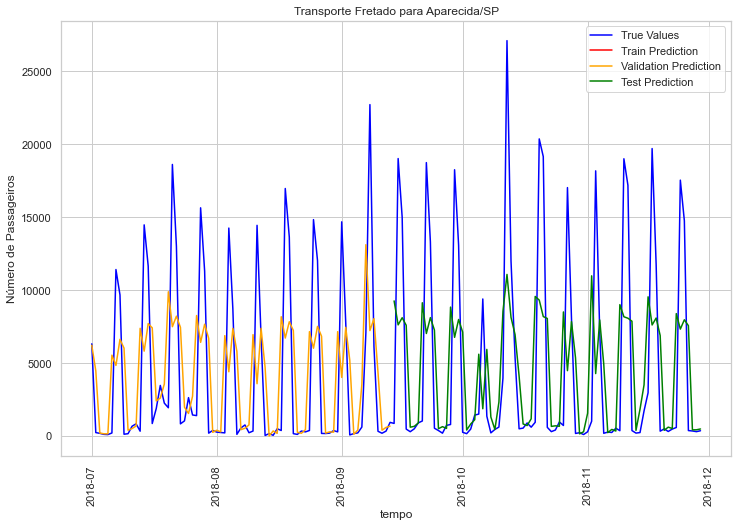

In [215]:
plot_graph_2(data.iloc[:, 0].values, data.index.values, trainPrediction, valPrediction, testPrediction, window)

## Performance Metrics

In [216]:
def root_mean_squared_error_loss(y_true, y_pred):
    import tensorflow as tf
    return tf.sqrt(tf.reduce_mean(tf.math.squared_difference(y_true, y_pred)))

def mean_squared_error(y_true, y_pred):
    from tensorflow.keras import backend
    backend.mean(backend.square(y_pred - y_true), axis=-1)

def rmse(y_true, y_pred):
    from tensorflow.keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))    
    

def model_evaluation(model, trainY, testY, trainPrediction, testPrediction):
    rmse_loss = root_mean_squared_error_loss(testY, testPrediction)
    mse = mean_squared_error(testY, testPrediction)
    print(mse)
    print('RMSE Loss: %.2f' % (rmse_loss))
    print('MSE: %.2f' % (mse))
    print('RMSE: %.2f' % (np.sqrt(mse)))
    

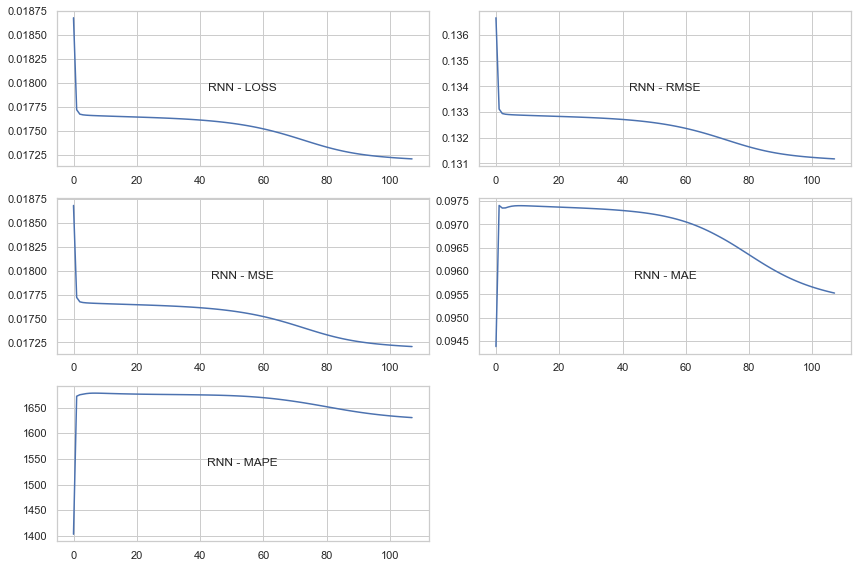

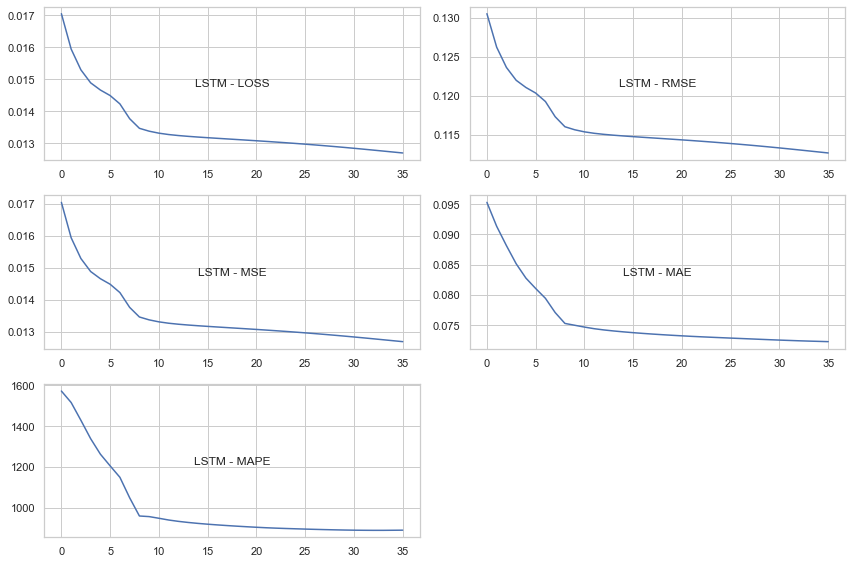

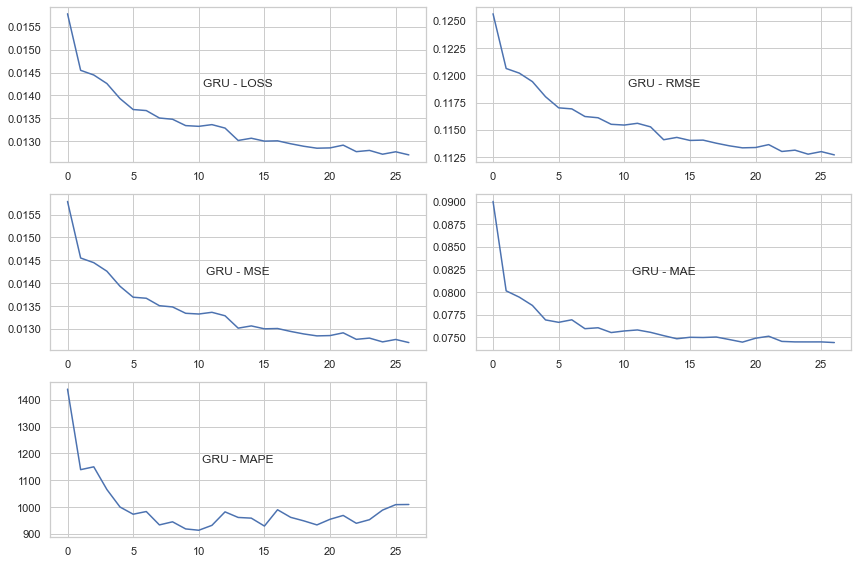

In [217]:
for l, h in zip(label, history):
	history_metrics = h.history
	history_metrics['rmse'] = np.sqrt(history_metrics['mse'])
	metric_list=['loss', 'rmse', 'mse', 'mae', 'mape']
	for i in range(len(metric_list)):
		# print(metric_list[i])
		# determine the plot number
		# plot_no = 420 + (i + 1)
		plt.subplot(3, 2, i + 1)
		# fit model and plot learning curves for a learning rate
		plt.title(l.upper() + ' - ' + metric_list[i].upper(), pad=-80)
		# plt.plot(history.history[metric_list[i]])
		plt.plot(history_metrics[metric_list[i]])
	# show learning curves
	plt.tight_layout()
	plt.show()

In [218]:
print("loss:{}\nrmse:{}\nmse:{}\nmae:{}\nmape:{}".format(history_metrics['loss'][0],
history_metrics['rmse'][0],
history_metrics['mse'][0],
history_metrics['mae'][0],
history_metrics['mape'][0]))

loss:0.015786753967404366
rmse:0.12564534996331686
mse:0.015786753967404366
mae:0.09004170447587967
mape:1439.3316650390625


In [219]:
history_size = len(history_metrics['rmse']) -1
print("loss:{}\nrmse:{}\nmse:{}\nmae:{}\nmape:{}".format(history_metrics['loss'][history_size],
history_metrics['rmse'][history_size],
history_metrics['mse'][history_size],
history_metrics['mae'][history_size],
history_metrics['mape'][history_size]))

loss:0.012701576575636864
rmse:0.1127012714020426
mse:0.012701576575636864
mae:0.07442119717597961
mape:1009.7891235351562


## Make Predictions

In [220]:
# Saving model
# model.save("../models/fret_rnn_d0.h5")

* **Making Predictions**

In [221]:

# identical to the previous one
# model = load_model('../models/fret_rnn_d0.h5')
# model.predict([0.9])

## CONCLUSION

We tried to workout on RNN with Keras library. Our predictions are not perfect but that seems enough for now :) I learned a lot of things from this project myself and I hope you did it too. Your examinations and comments are so important to me. Please, check it out and feel relax to comment me. 